# Сборный проект 2 | HR-аналитика

## Оглавление<a name="0"></a> 

* [Оглавление](#0)
* [Задача 1: предсказание уровня удовлетворённости сотрудника](#1)
    * [Импорт библиотек](#2)
    * [Заведение функций](#3)
    * [Загрузка данных](#4)
    * [Предобработка данных](#5)
    * [Исследовательский анализ данных](#6)
        * [Анализ значений и пропорций](#7)
        * [Корреляционный анализ](#8)
    * [Работа с моделями](#9)
        * [Подготовка признаков](#10)
        * [Выстраивание пайплайна](#11)
        * [Применение пайплайна](#12)
            * [Создание кастомной метрики качества](#13)
            * [Активация пайплайна](#14)
    *[ Итоговый вывод задачи №1](#15)
* [Задача 2: Предсказание увольнения сотрудника из компании](#16)
    * [Загрузка данных](#17)
    * [Предобработка данных](#18)
    * [Исследовательский анализ данных](#19)
        * [Численный анализ](#20)
        * [Портрет уволившегося сотрудника](#21)
        * [Проверка гипотезы аналитиков](#22)
    * [Добавление нового входного признака](#23)
    * [Подготовка данных](#24)
    * [Работа с новым пайплайном](#25)
        * [Подвывод по модели 2](#26)
   * [Итоговый вывод | Задача 2](#27)
* [Советы бизнесу](#28)

# Задача 1: предсказание уровня удовлетворённости сотрудника<a name="1"></a> 

Проект выполнен для компании «Работа с заботой», которая специализируется на HR-аналитике, помогая бизнесу эффективно управлять персоналом, минимизировать финансовые потери и сокращать отток сотрудников. Для повышения точности и скорости рекомендаций бизнесу аналитики компании используют методы машинного обучения.

Для выполнения поставленных задач предоставлен датасет, содержащий характеристики сотрудников и показатели их удовлетворённости работой, полученные из результатов тест-опросников. Уровень удовлетворённости варьируется от 0 (полностью неудовлетворён) до 1 (полностью удовлетворён). Однако сбор таких данных представляет собой сложный процесс ввиду большого размера компании.

Проект включает две основные задачи:

1. Разработка модели машинного обучения, способной прогнозировать уровень удовлетворённости сотрудников на основе предоставленных характеристик.
2. Создание модели, которая будет предсказывать вероятность увольнения сотрудника.

Эти задачи важны для бизнеса, так как удовлетворённость сотрудников напрямую связана с риском их увольнения, что может привести к значительным организационным и финансовым потерям, особенно при уходе ключевых сотрудников.


## Импорт библиотек<a name="2"></a> 

In [1]:
RANDOM_STATE = 42

In [2]:
#!pip install lightgbm

In [3]:
#pip install --upgrade scikit-learn numpy threadpoolctl shap

In [4]:
#!pip install phik

In [5]:
import pandas as pd
import math
import inspect
from typing import List
import seaborn as sns
import numpy as np
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# для RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# модели
from sklearn.linear_model        import LinearRegression
from sklearn.tree                import DecisionTreeRegressor
from sklearn.tree                import DecisionTreeClassifier
from lightgbm                    import LGBMRegressor, LGBMClassifier
from sklearn.ensemble            import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors           import KNeighborsRegressor, KNeighborsClassifier

## Заведение функций<a name="3"></a> 

In [6]:
#Штука для комплексной предобработки данных

def describe_dataset(df):
    frame = inspect.currentframe().f_back
    name = next((n for n, v in frame.f_locals.items() if v is df), 'Dataset')
    print(f'Название датасета: {name}')
    print('Пример строк (sample 3):')
    display(df.sample(3))
    print(f'Количество пропусков: {df.isnull().sum().sum()}')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('Информация о датасете (info):')
    df.info()
    print('==================\n')

In [7]:
# Анализ неявного дублицирования
def show_non_numeric(df):
    frame = inspect.currentframe().f_back
    name = next((n for n, v in frame.f_locals.items() if v is df), 'DataFrame')
    print(f'Название датафрейма: {name}')
    
    non_numeric = df.select_dtypes(exclude='number')
    if non_numeric.empty:
        print('В датафрейме нет нечисловых столбцов.')
    else:
        print('Уникальные нечисловые значения:')
        for col in non_numeric.columns:
            uniques = non_numeric[col].dropna().unique()
            print(f'  {col}: {list(uniques)}')
    
    print('-' * 40)
    print()


In [8]:
#Ходит по датафрейму и собирает NaNы в лукошко

def get_nan_columns(df: pd.DataFrame) -> list[str]:
    nan_mask = df.isna().any()
    return nan_mask[nan_mask].index.tolist()

In [9]:
def apply_imputer_to_dfs(
    dfs: List[pd.DataFrame],
    imputer_pipeline
) -> List[pd.DataFrame]:
    filled_dfs = []
    for df in dfs:
        cols_with_nan = get_nan_columns(df)
        if cols_with_nan:
            df_filled = df.copy()
            # преобразуем только нужные столбцы
            filled_vals = imputer_pipeline.fit_transform(df_filled[cols_with_nan])
            # обратно в DataFrame с теми же индексами и именами колонок
            df_filled[cols_with_nan] = pd.DataFrame(
                filled_vals,
                index=df_filled.index,
                columns=cols_with_nan
            )
            filled_dfs.append(df_filled)
        else:
            # если нет пропусков — оставляем как есть
            filled_dfs.append(df)
    return filled_dfs

In [10]:
#Строит гистограммы количественных признаков и их боксплоты

def plot_numeric_histograms(df: pd.DataFrame,
                            hue_col: str = None,
                            bins: int = 30,
                            figsize: tuple = (12, 8),
                            discrete_cols: list = None):

    # по умолчанию дискретные колонки:
    if discrete_cols is None:
        discrete_cols = ['employment_years', 'supervisor_evaluation']
    
    # убираем id, если есть
    df_plot = df.drop(columns=[c for c in ["id"] if c in df.columns])
    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns
    n = len(numeric_cols)
    if n == 0:
        print("В датафрейме нет числовых признаков.")
        return
    
    # подготовка холстов
    fig, axes = plt.subplots(n, 2, figsize=figsize)
    if n == 1:
        axes = np.array([axes])
    
    cmap = plt.get_cmap('tab10')
    
    for i, col in enumerate(numeric_cols):
        ax_main = axes[i, 0]
        ax_side = axes[i, 1]
        
        # если дискретная колонка — рисуем countplot и прячем боксплот
        if col in discrete_cols:
            if hue_col and hue_col in df_plot.columns:
                sns.countplot(data=df_plot, x=col, hue=hue_col, ax=ax_main)
            else:
                sns.countplot(data=df_plot, x=col, ax=ax_main)
            ax_main.set_title(f"Countplot для {col}", fontsize=10, pad=10)
            ax_main.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
            
            # прячем второй график
            ax_side.axis('off')
        
        # иначе — гистограмма + боксплот
        else:
            data = df_plot[col].dropna()
            # гистограмма
            ax_main.hist(data, bins=bins, density=True, alpha=0.7)
            mean_val = data.mean()
            ax_main.axvline(mean_val, linestyle='--', linewidth=1)
            ax_main.text(0.95, 0.95, f"mean={mean_val:.2f}",
                         transform=ax_main.transAxes,
                         ha='right', va='top', fontsize=8)
            ax_main.set_title(f"Гистограмма {col}", fontsize=10, pad=10)
            ax_main.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
            
            # боксплот
            if hue_col and hue_col in df_plot.columns:
                hue_vals = df_plot[hue_col].dropna().unique()
                groups = [df_plot[df_plot[hue_col] == val][col].dropna()
                          for val in hue_vals]
                labels = [str(val) for val in hue_vals]
                groups.append(data); labels.append('All')
                bp = ax_side.boxplot(groups, vert=False, labels=labels, patch_artist=True)
                for j, box in enumerate(bp['boxes']):
                    box.set_facecolor(cmap(j % cmap.N))
                ax_side.set_title(f"{col} (boxplot by {hue_col} + all)",
                                  fontsize=10, pad=10)
            else:
                bp = ax_side.boxplot(data, vert=False, patch_artist=True)
                bp['boxes'][0].set_facecolor(cmap(0))
                ax_side.set_title(f"{col} (boxplot)", fontsize=10, pad=10)
            ax_side.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [11]:
#Пайчарты категориальных признаков

def plot_non_numeric_pies(df):
    non_numeric = df.select_dtypes(exclude='number')
    cols = non_numeric.columns.tolist()
    n = len(cols)
    if n == 0:
        print('В датафрейме нет нечисловых столбцов.')
        return

    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cols):
        counts = df[col].value_counts(dropna=False)
        ax.pie(
            counts.values,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False
        )
        ax.set_title(f'"Распределение признаков колонки {col}"')
        ax.axis('equal')

    plt.tight_layout()
    plt.show()


In [12]:
# Строит все боксплоты для анализа одного признака

def plot_job_satisfaction_boxplots(df: pd.DataFrame, features: list, figsize: tuple = (5, 6)):
    valid_feats = [f for f in features if f in df.columns]
    if not valid_feats:
        print("Нет доступных признаков для построения боксплотов.")
        return
    n = len(valid_feats)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0] * n, figsize[1]))
    if n == 1:
        axes = [axes]

    cmap = plt.get_cmap('tab10')

    for ax, feature, color_idx in zip(axes, valid_feats, range(n)):
        categories = df[feature].dropna().unique()
        groups = [df[df[feature] == cat]['job_satisfaction_rate'].dropna() for cat in categories]
        labels = [str(cat) for cat in categories]
        bp = ax.boxplot(groups, vert=False, labels=labels, patch_artist=True)
        for j, box in enumerate(bp['boxes']):
            box.set_facecolor(cmap(j % cmap.N))
        ax.set_title(f"{feature}", fontsize=10, pad=10)
        ax.set_xlabel('job_satisfaction_rate')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

In [13]:
#Смотрим на уволившихся

def plot_quit_rate_by_all_categories(df: pd.DataFrame, max_cols: int = 2, max_unique_values: int = 30):
    candidate_cols = [
        col for col in df.columns
        if col != 'quit' and (
            df[col].dtype in ['object', 'category', 'bool'] or
            (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() <= max_unique_values)
        )
    ]
    
    n = len(candidate_cols)
    n_cols = min(max_cols, n)
    n_rows = math.ceil(n / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6.5, n_rows * 5))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(candidate_cols):
        quit_rate = df.groupby(col)['quit'].mean().sort_values()
        categories = quit_rate.index.astype(str)
        values = quit_rate.values

        norm = plt.Normalize(values.min(), values.max())
        colors = plt.cm.viridis(norm(values))

        sns.barplot(x=values, y=categories, palette=colors, ax=axes[i])
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('Доля уволившихся')
        axes[i].set_ylabel('')
        axes[i].set_xlim(0, 1)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Загрузка данных<a name="4"></a> 

Загрузим и изучим данные. Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [14]:
try:
    job_X_train = pd.read_csv('train_job_satisfaction_rate.csv')
    display(job_X_train.sample(3))
except:
    job_X_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    display(job_X_train.sample(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
830,806693,marketing,junior,medium,1,no,no,2,30000,0.30
3858,317985,purchasing,middle,medium,6,no,no,5,39600,0.90
2358,711636,sales,junior,medium,1,no,no,4,27600,0.66


In [15]:
try:
    job_X_test = pd.read_csv('test_features.csv')
    display(job_X_test.sample(3))
except:
    job_X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    display(job_X_test.sample(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
398,463515,sales,junior,low,2,no,no,1,18000
540,193965,sales,middle,high,4,no,no,3,52800
707,581311,hr,middle,medium,5,no,yes,3,43200


In [16]:
try:
    job_y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    display(job_y_test.head())
except:
    job_y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')
    display(job_y_test.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## Предобработка данных<a name="5"></a> 

Прежде чем работать с данными, стоит их предобработать. Для этого:
* Проверим пропуски
* Проверим дубликаты
* Проверим типы данных
* Проверим неявные дубликаты 

In [17]:
dfs = [job_X_train, job_X_test, job_y_test]

for entry in dfs:
    describe_dataset(entry)

Название датасета: job_X_train
Пример строк (sample 3):


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
502,752399,sales,middle,low,7,no,no,4,28800,0.77
3832,247544,technology,junior,medium,4,no,no,2,30000,0.41
2190,530874,sales,junior,high,1,no,no,4,31200,0.69


Количество пропусков: 10
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Название датасета: job_X_test
Пример строк (sample 3):


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1575,169164,hr,middle,medium,5,yes,no,4,34800
531,508816,sales,middle,high,8,no,no,4,54000
1902,532619,technology,junior,low,1,no,no,3,21600


Количество пропусков: 3
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Название датасета: job_y_test
Пример строк (sample 3):


,id,job_satisfaction_rate
323,957856,0.53
166,430991,0.15
1714,684749,0.97


Количество пропусков: 0
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB



**Подвывод:**

1) job_X_train:
    * 4000 значений
    * Количество пропусков: 10
    * Количество дубликатов: 0
    * Типы данных верны
2) job_X_test:
    * 2000 значений
    * Количество пропусков: 3
    * Количество дубликатов: 0
    * Типы данных верны
3) job_y_test:
    * 2000 значений
    * Количество пропусков: 0
    * Количество дубликатов: 0
    * Типы данных верны

Итого: до обработки неявных дубликатов нужно только обработать явные дубликаты. Реализую это через пайплайн.

In [18]:
imputer_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

Теперь проанализирую неявные дубликаты (только у категориальных переменных):

In [19]:
for entry in dfs:
    show_non_numeric(entry)

Название датафрейма: job_X_train
Уникальные нечисловые значения:
  dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing']
  level: ['junior', 'middle', 'sinior']
  workload: ['medium', 'high', 'low']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: job_X_test
Уникальные нечисловые значения:
  dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', ' ']
  level: ['junior', 'middle', 'sinior']
  workload: ['medium', 'low', 'high', ' ']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: job_y_test
В датафрейме нет нечисловых столбцов.
----------------------------------------



В результате проверки на неявные дубликаты выяснили:

1) **job_X_train**

Нет проблем

2) **job_X_test**

* dept - пустая строка
* level - sinior (правильно - senior)
* workload - пустая строка

3) **job_y_test**

Нет проблем

Теперь исправим все ошибки

In [20]:
job_X_test['level'].replace({'sinior': 'senior'}, inplace=True)
job_X_test['dept'].replace({' ': np.nan}, inplace=True)
job_X_test['workload'].replace({' ': np.nan}, inplace=True)

#new_dfs = apply_imputer_to_dfs(dfs, imputer_pipeline)
#==============ДОБАВЛЕНО==============
job_X_train['level'].replace({'sinior': 'senior'}, inplace=True)

def apply_imputer_to_dfs(
    dfs: List[pd.DataFrame],
    imputer_pipeline
) -> List[pd.DataFrame]:
    # обучаем на первой (train) таблице
    train = dfs[0]
    train_cols = get_nan_columns(train)
    if train_cols:
        imputer_pipeline.fit(train[train_cols])

    # применяем к каждой
    filled_dfs = []
    for df in dfs:
        df_copy = df.copy()
        # только те столбцы, что были в train
        common = [c for c in train_cols if c in df_copy.columns]
        if common:
            vals = imputer_pipeline.transform(df_copy[common])
            df_copy[common] = pd.DataFrame(
                vals,
                index=df_copy.index,
                columns=common
            )
        filled_dfs.append(df_copy)
    return filled_dfs

dfs = [job_X_train, job_X_test, job_y_test]

# fit_transform апплаим на train и transform на остальные
new_job_X_train, new_job_X_test, new_job_y_test = apply_imputer_to_dfs(
    dfs,
    imputer_pipeline
)

# перезаписываем исходные переменные
job_X_train, job_X_test, job_y_test = (
    new_job_X_train,
    new_job_X_test,
    new_job_y_test
)

# пушу в новый список
new_dfs = dfs


Пройдемся по всем шагам предобработки вновь и проверим - не осталось ли там чего лишнего...

In [21]:
for entry in new_dfs:
    describe_dataset(entry)

Название датасета: entry
Пример строк (sample 3):


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1703,927443,technology,junior,medium,4,no,no,4,34800,0.82
2734,561561,technology,middle,low,2,no,no,4,34800,0.65
575,844327,sales,junior,medium,1,no,no,3,21600,0.14


Количество пропусков: 10
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Название датасета: entry
Пример строк (sample 3):


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
391,362664,hr,middle,medium,5,yes,no,5,42000
176,479601,marketing,middle,medium,7,no,yes,3,40800
325,120300,sales,middle,medium,5,yes,no,4,38400


Количество пропусков: 5
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Название датасета: entry
Пример строк (sample 3):


,id,job_satisfaction_rate
794,583191,0.18
1197,648081,0.49
1542,510330,0.53


Количество пропусков: 0
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB



In [22]:
for entry in new_dfs:
    show_non_numeric(entry)

Название датафрейма: entry
Уникальные нечисловые значения:
  dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing']
  level: ['junior', 'middle', 'senior']
  workload: ['medium', 'high', 'low']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: entry
Уникальные нечисловые значения:
  dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology']
  level: ['junior', 'middle', 'senior']
  workload: ['medium', 'low', 'high']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: entry
В датафрейме нет нечисловых столбцов.
----------------------------------------



In [23]:
dfs = new_dfs

job_X_train = dfs[0]
job_X_test = dfs[1]
job_y_test = dfs[2]

In [24]:
for entry in new_dfs:
    show_non_numeric(entry)

Название датафрейма: job_X_train
Уникальные нечисловые значения:
  dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing']
  level: ['junior', 'middle', 'senior']
  workload: ['medium', 'high', 'low']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: job_X_test
Уникальные нечисловые значения:
  dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology']
  level: ['junior', 'middle', 'senior']
  workload: ['medium', 'low', 'high']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
----------------------------------------

Название датафрейма: job_y_test
В датафрейме нет нечисловых столбцов.
----------------------------------------



Ошибок больше нет. Что было сделано:

1) Пропущенные числовые значения заменены на самые часто втречающиеся при помощи пайплайна SimpleImputer
2) Пропущенные категориальные значения заменены на NaN
3) Была исправлена синтаксическая ошибка (sinior --> senior)

## Исследовательский анализ данных<a name="6"></a> 

### Анализ значений и пропорций<a name="7"></a> 

Выведем графики признаков:

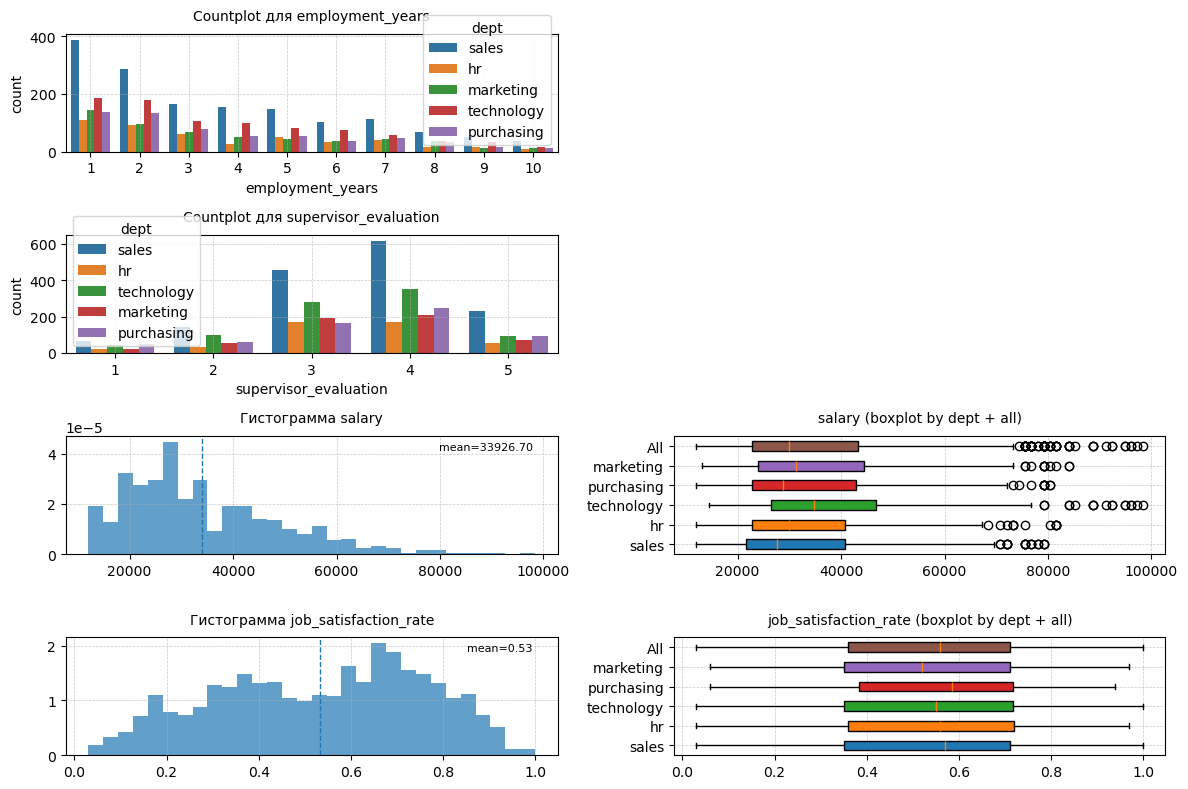

In [25]:
plot_numeric_histograms(job_X_train, 'dept')

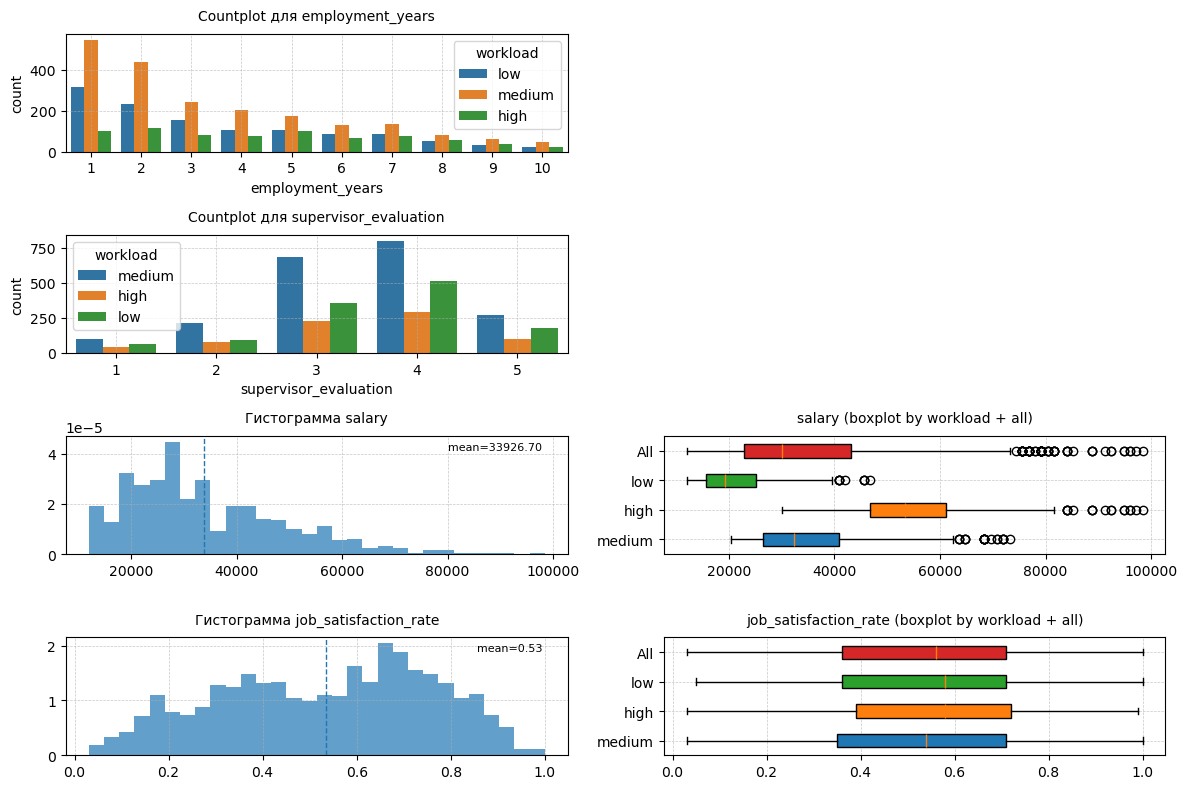

In [26]:
plot_numeric_histograms(job_X_train, 'workload')

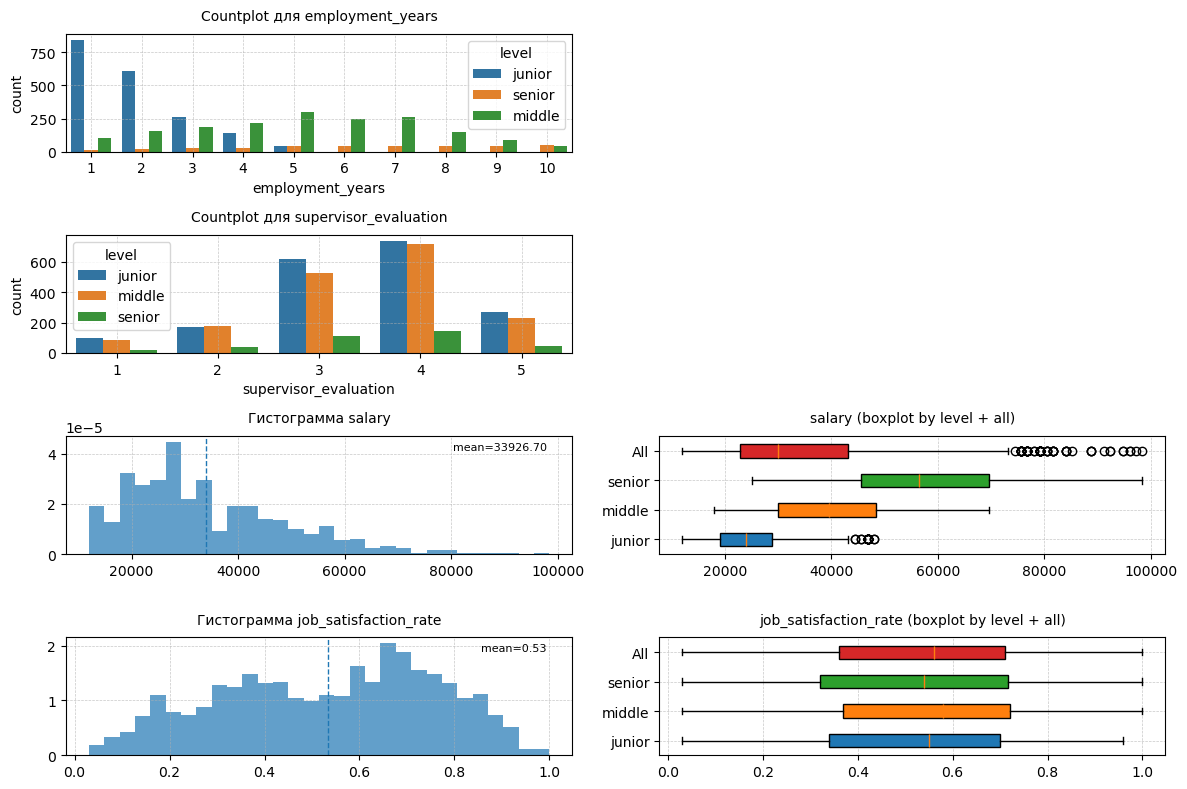

In [27]:
plot_numeric_histograms(job_X_train, 'level')

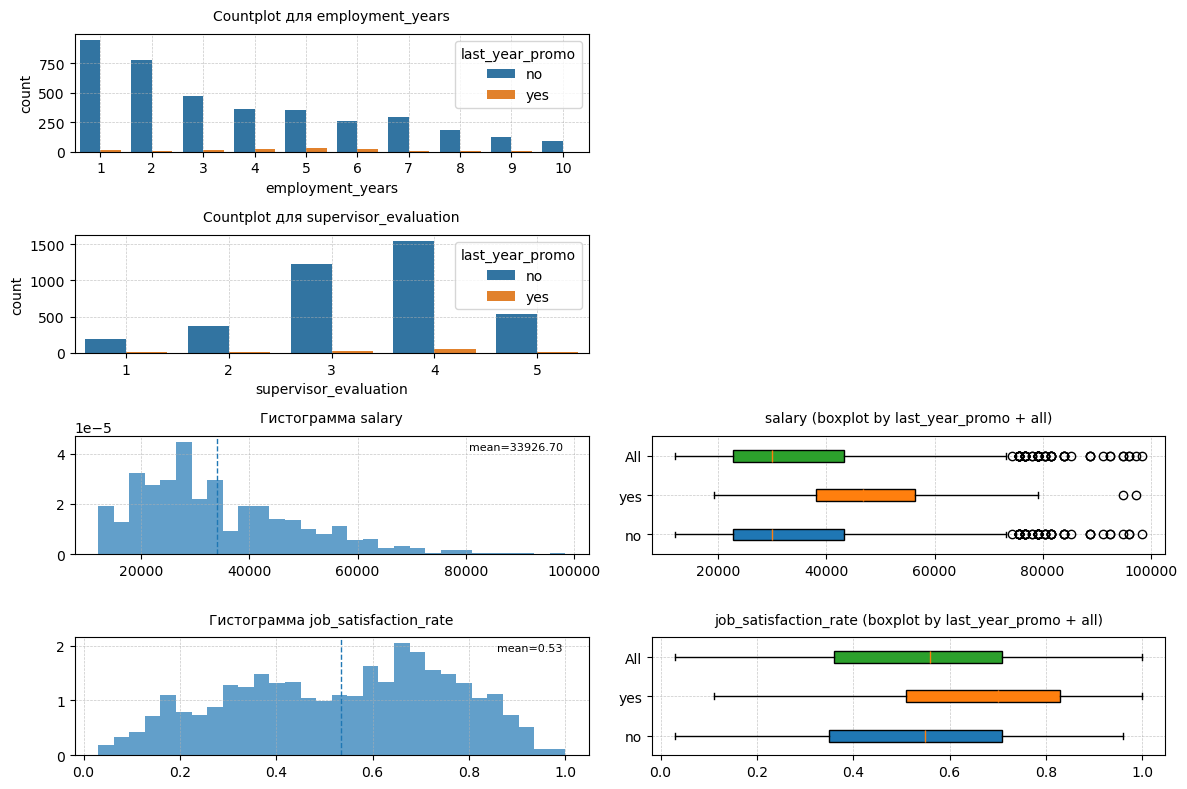

In [28]:
plot_numeric_histograms(job_X_train, 'last_year_promo')

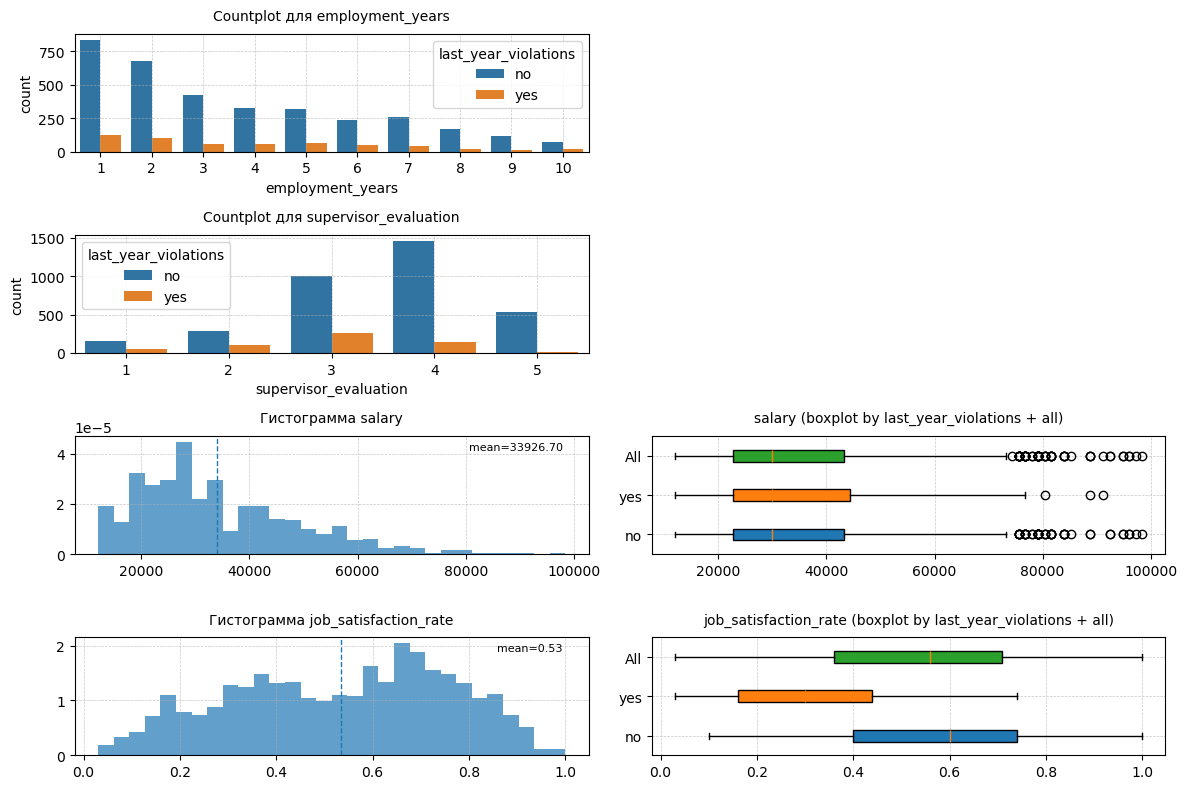

In [29]:
plot_numeric_histograms(job_X_train, 'last_year_violations')

Какие не очевидные выводы можно сделать из графиков выше?

1) Статистически, больше всех получают IT-шники, а меньше всех - департамент продаж. Неравенство оплаты туда может влиять на желание сотрудников оставаться на своем месте
2) Дольше в компании задерживаются те сотрудники, которых недавно повышают. Наверное, это очень важно для профессиональной мотивации
3) Те, кто недавно получал выговор намного меньше удовлетворены своей работой. Интересно, что было первым? Неудовлетворенность вызвала пофигизм и наплевательство или Наказания заставили опустить сотрудников руки? Это мы выясним

Для простоты анализа, выведем все боксплоты удовлетвореннгости в разрезе категориальных признаков

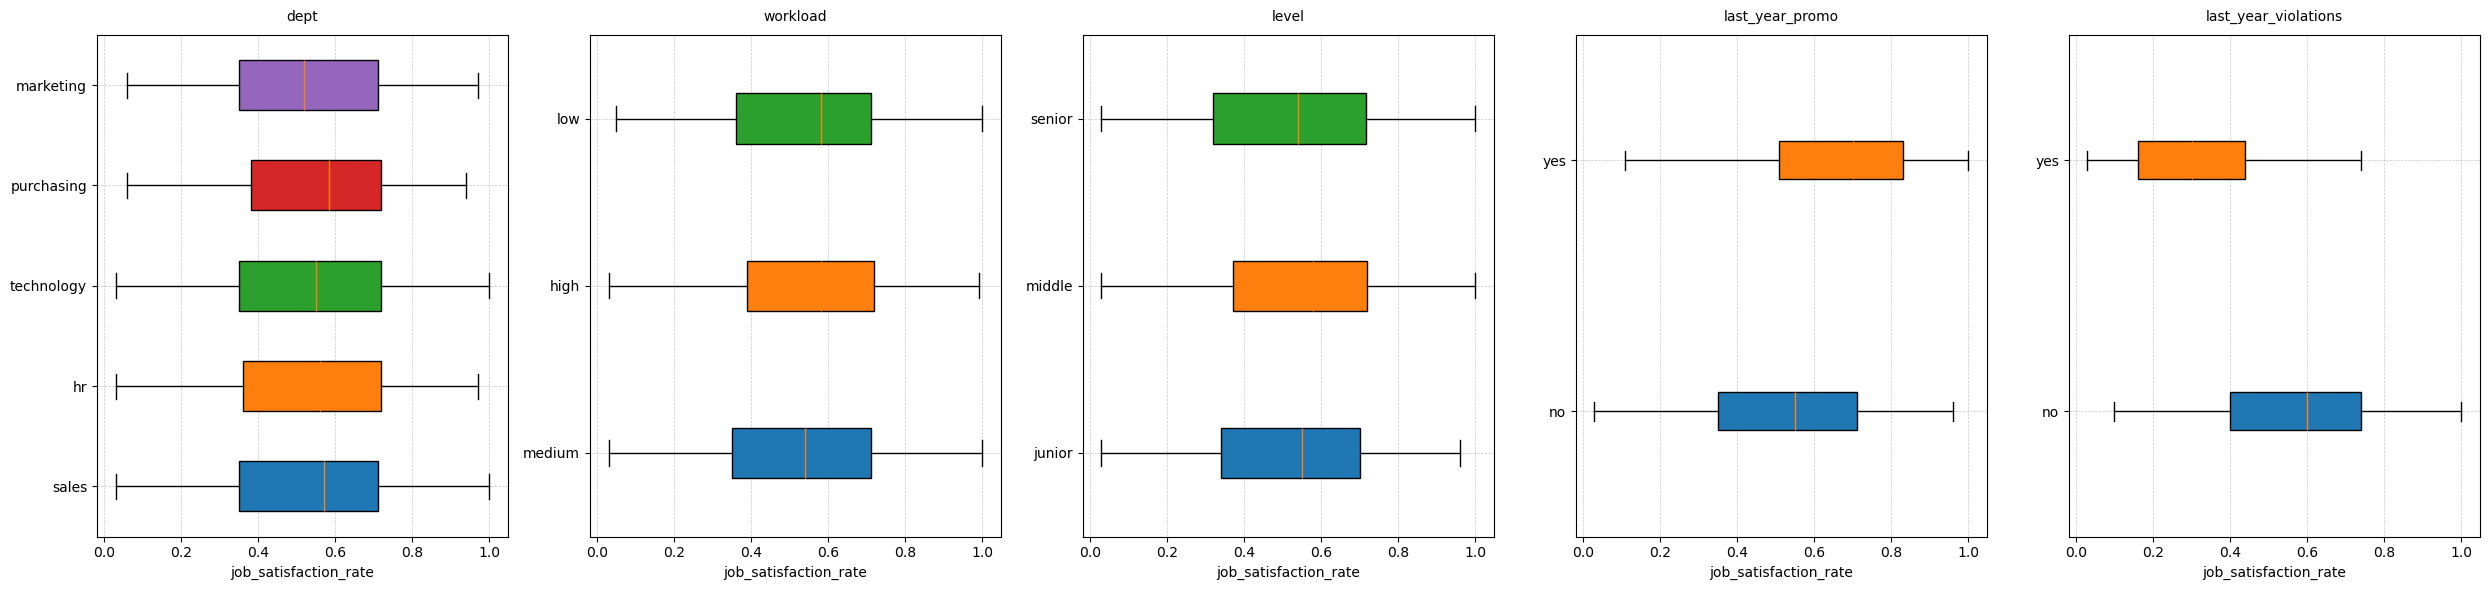

In [30]:
plot_job_satisfaction_boxplots(job_X_train, ['dept', 'workload', 'level', 'last_year_promo', 'last_year_violations'])

С числовыми признаками закончили. Давайте взглянем на дистрибуцию качественных признаков. Лучше всего для этого подойдет pie chart

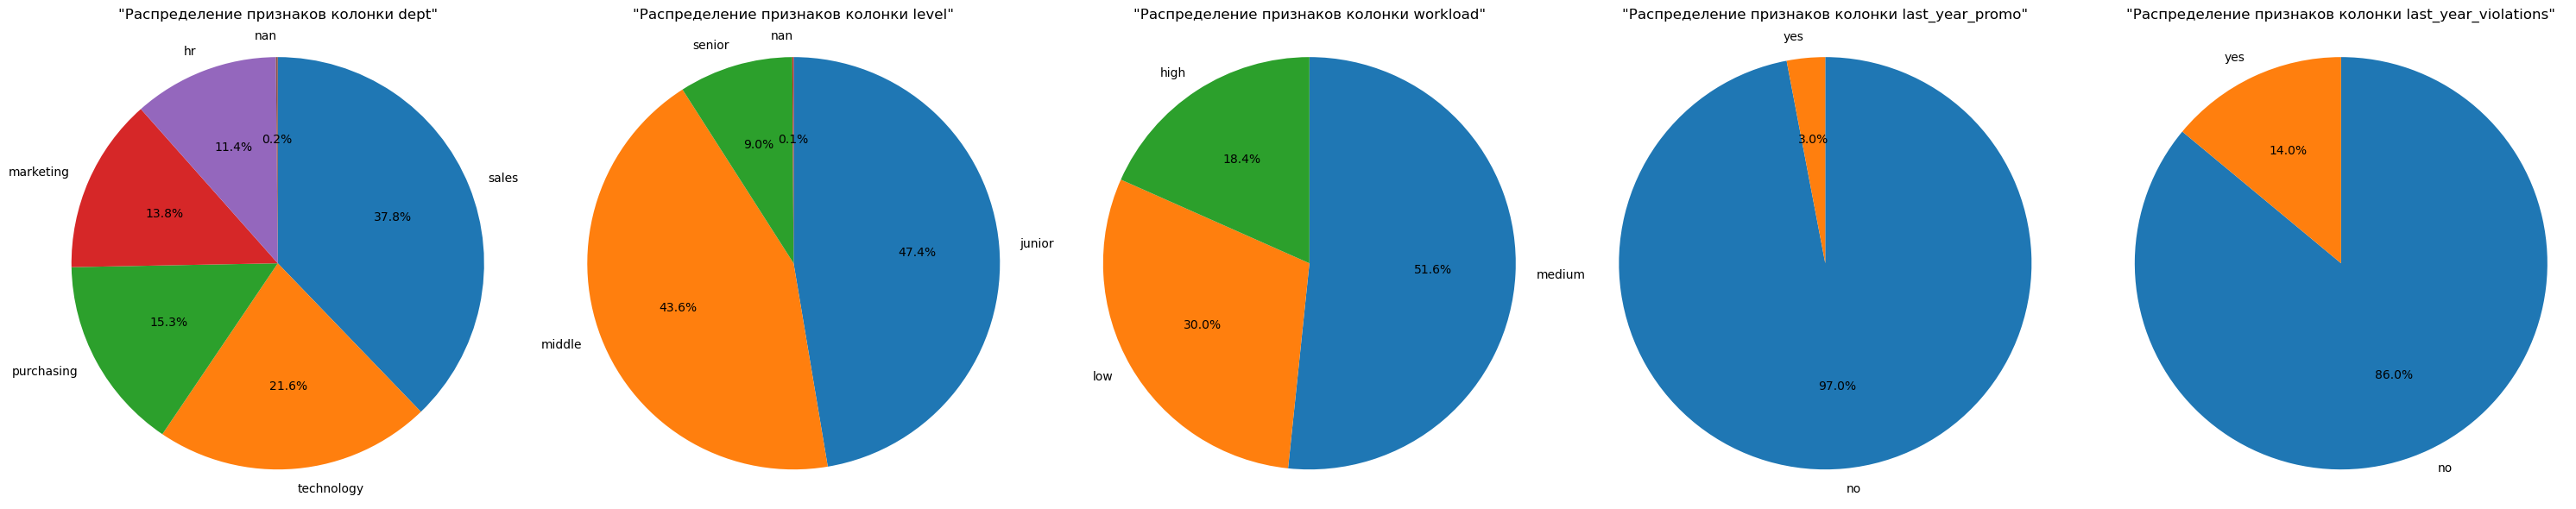

In [31]:
plot_non_numeric_pies(job_X_train)

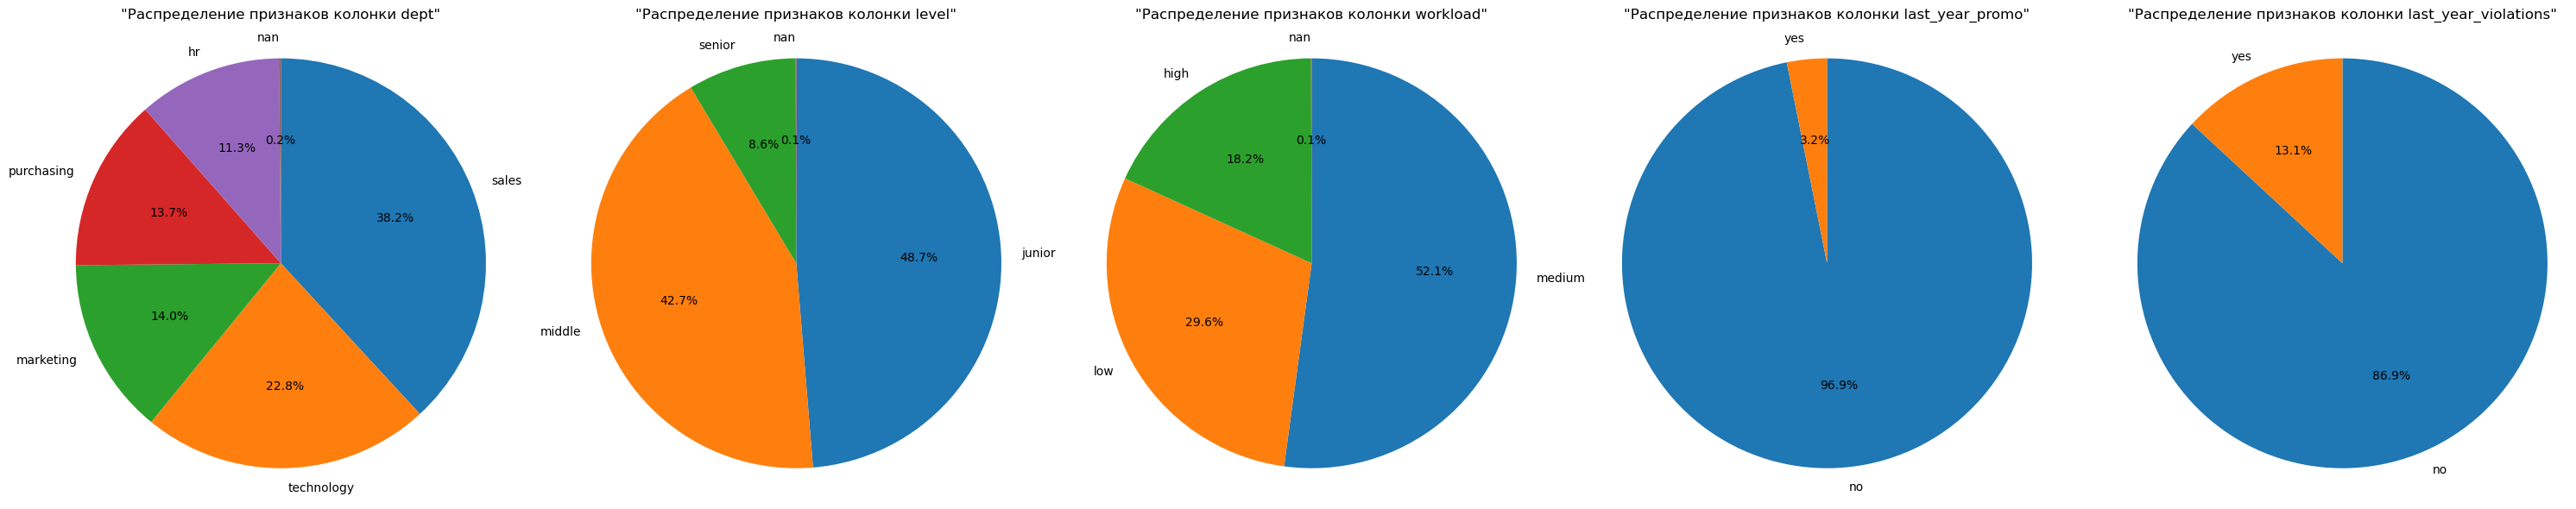

In [32]:
plot_non_numeric_pies(job_X_test)

Как следует из графиков выше:

1) В компании больше всего бедных продажников. Возможно их низкая оплата труда в купе с их количеством делают компании плохую статистику по текучке?
2) Уравновешивает их второй по численности штат айтишников, которые, веротяно, довольны своей заработной платой (особенно сеньоры и мидлы), которых более половины
3) В компании очень мало повышают, но при этом намного чаще делают выговоры. Вероятно, это тоже играет свою роль и руководство рассмотрит идею о пересмотре соотношения кнута и пряника в управленческих процессах
4) Примерные пропорции данных в тестовой и обучающей выборке сопадают. Это позволяет нам правильно распространять выводы и результаты обучения тестовой выборки

### Корреляционный анализ<a name="8"></a> 

Построю мтатрицу корреляций phi(K), чтобы сэкономить время и сразу посмотреть на связь всех признаков:

In [33]:
interval_cols = [
    'salary',
    'job_satisfaction_rate',
]

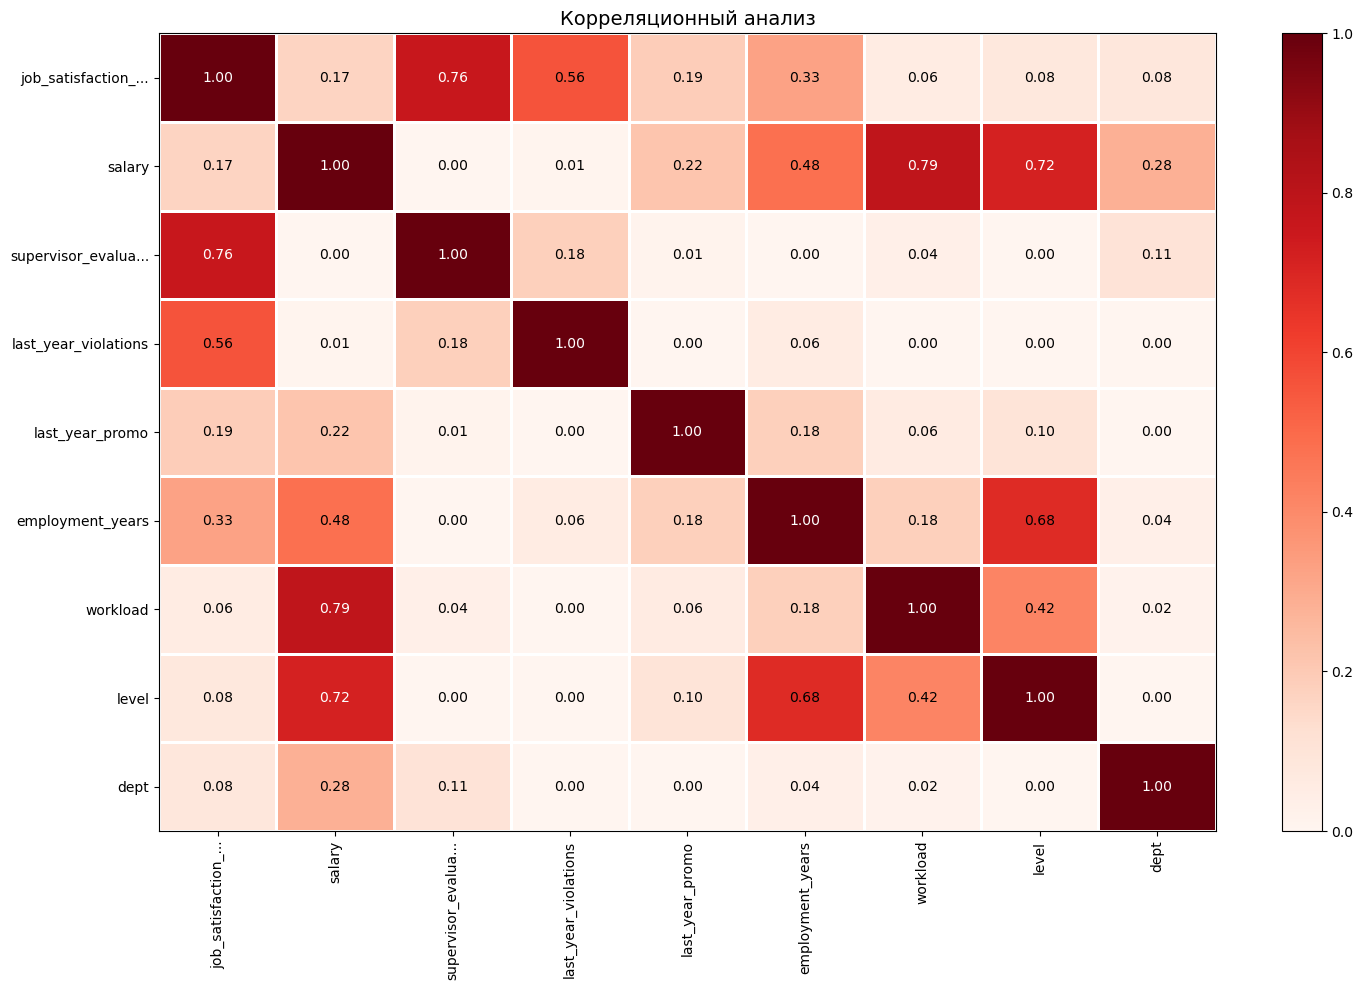

In [34]:
phik_overview = phik_matrix(job_X_train.drop('id', axis=1), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

По результатам корреляционного анализа можно сделать следующие выводы:

* Сильнее всего целевой признак (job_satisfaction) коррелирует с оценкой супервайзера, наличием нарушений в прошлом году и с количеством отработанных лет. Веротяно, не хорошо работают те, кого высоко оценили, а высоко оценивают тех, кто доволен работой и делает ее хорошо.
* Удовлетворённость сильно связана с оценкой руководителя (≈0.76), но мало — с зарплатой (≈0.17).
* Оклад коррелирует с нагрузкой (≈0.79), уровнем (≈0.72) и стажем (≈0.48).
* Нарушения прошлого года почти не зависят от зарплаты и уровня, но умеренно связаны с удовлетворённостью (≈0.56) и оценкой босса (≈0.18).
* Повышения за год слабо коррелируют с зарплатой (≈0.22) и стажем (≈0.18), практически не с нарушениями.
* Материальные и статусные метрики (уровень, нагрузка, оклад) образуют один кластер, а эмоциональные показатели (удовлетворённость, нарушения) — скорее отражают качество руководства.


Дополнительно проведу корреляционный анализ для тестовой выборки, так как мы не сами занимались разделением данных на выборки, мы должны убедиться, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на test выборке, будет корректной.

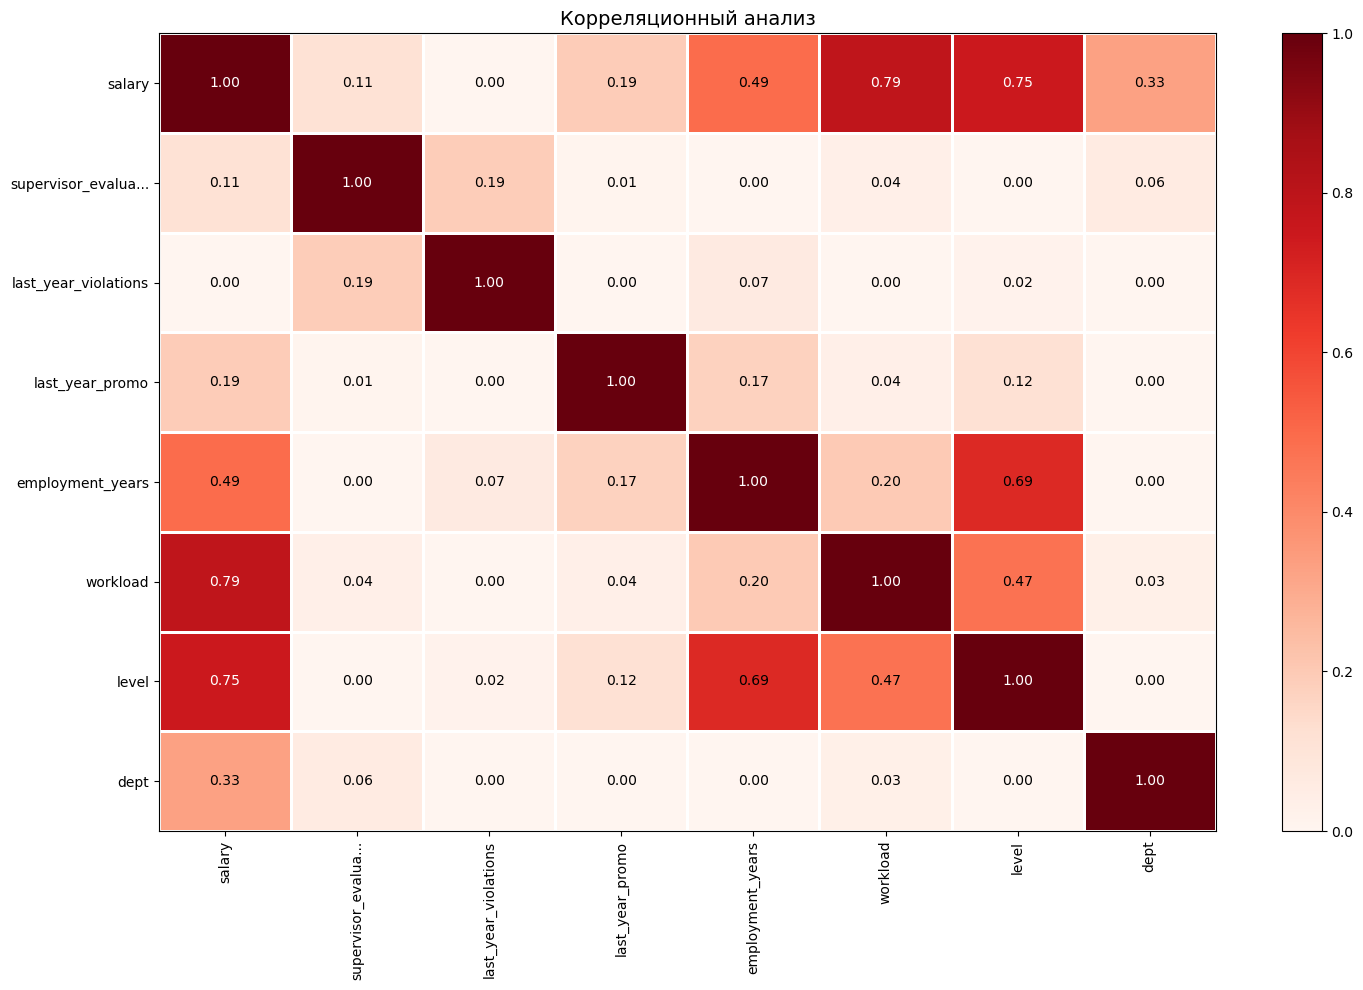

In [35]:
phik_overview = phik_matrix(job_X_test.drop('id', axis=1), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

Проанализировав две матрицы корреляции, можно гвоорить о том, что нет существенных различий в части распределений признаков

1) salary-last_year_violations (0.00~0.01)
2) level-enployment_years (0.69~0.68)
3) dept-supervisor_evaluation (0.06~0.11)

## Работа с моделями<a name="9"></a> 

### Подготовим признаки<a name="10"></a> 

In [36]:
job_X_train

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [37]:
# =======TRAIN=======
job_train = job_X_train.set_index('id')
print("Полных дубликатов в train:", job_train.duplicated().sum())

job_train = job_train.drop_duplicates()
job_y_train_ml = job_train['job_satisfaction_rate']
job_X_train_ml = job_train.drop('job_satisfaction_rate', axis=1)


# =======TEST=======
job_test_X = job_X_test.set_index('id')
job_test_y = job_y_test.set_index('id')
job_full_test = job_test_X.merge(job_test_y, left_index=True, right_index=True)

print("Полных дубликатов в test:", job_full_test.duplicated().sum())

#job_full_test = job_full_test.drop_duplicates()
job_y_test_ml = job_full_test['job_satisfaction_rate']
job_X_test_ml = job_full_test.drop('job_satisfaction_rate', axis=1)

Полных дубликатов в train: 245
Полных дубликатов в test: 83


### Выстроим пайплайн<a name="11"></a> 

In [38]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Применение пайплайна<a name="12"></a> 

#### Создание кастомной метрики качества<a name="13"></a> 

Создана как функция SMAPE 

In [39]:
#SMAPE метрика

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    
    # Считаем знаменатель: среднее из абсолютных истинных и прогнозных значений
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    
    # Абсолютная ошибка
    diff = np.abs(y_true - y_pred)
    
    # Избегаем деления на ноль: там, где denom == 0, вклад считаем нулевым
    mask = denom != 0
    smape_elements = np.zeros_like(diff)
    smape_elements[mask] = diff[mask] / denom[mask]
    
    return 100.0 * np.mean(smape_elements)

smape_score = make_scorer(smape, greater_is_better=False)

#### Активация пайплайна<a name="14"></a> 

In [40]:
param_grid = [
    {
      'models': [LinearRegression()],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
      'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
      'models__max_depth': range(1, 21),
      'models__min_samples_leaf': range(1, 6),
      'models__min_samples_split': range(2, 6),
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
      'models': [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
      'models__n_estimators': range(10, 100),
      'models__max_depth': range(1, 21),
      'models__min_samples_leaf': range(1, 6),
      'models__min_samples_split': range(2, 6),
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
      'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
      'models__n_estimators': range(10, 100),
      'models__max_depth': range(1, 21),
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
      'models': [KNeighborsRegressor(n_jobs=-1, weights='distance')],
      'models__n_neighbors': range(5, 20),
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
]


In [41]:
rs = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    n_iter=100,
    cv=10,
    scoring=smape_score,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Подбираем гиперпараметры ТОЛЬКО на train
rs.fit(job_X_train_ml, job_y_train_ml)
job_y_test_pred = rs.best_estimator_.predict(job_X_test_ml)
print("Лучшая модель и гиперпараметры:", rs.best_estimator_)
print("SMAPE на CV (train):", -rs.best_score_)


Лучшая модель и гиперпараметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [42]:
# Только одна модель — rs.best_estimator_
y_test_pred = rs.best_estimator_.predict(job_X_test_ml)
print("SMAPE на тесте:", smape(job_y_test_ml, y_test_pred))


SMAPE на тесте: 11.936609427550678


Учитывая, что чем меньше метрика - тем лучше, то самой луяшей моделью стала

LGBMRegressor(max_depth=14, n_estimators=97, n_jobs=-1, random_state=42,
              verbose=-1)
1. SMAPE лучшей модели на кросс-валидации (TRAIN): 12.98
2. SMAPE (TEST): 12.0837

Буду работать с ней

1) Большое количество итераций для модели позволило ее улучшить и получить значение на тестовой выборке 10.79 (прирост качества 5.8 п.п.)
2) Уточненная лучшая модель - это LGBMRegressor(max_depth=13, n_estimators=145)

Оценим важность полученных признаков, чтобы выяснить что влияет сильнее всего на удовлетворенность работой:

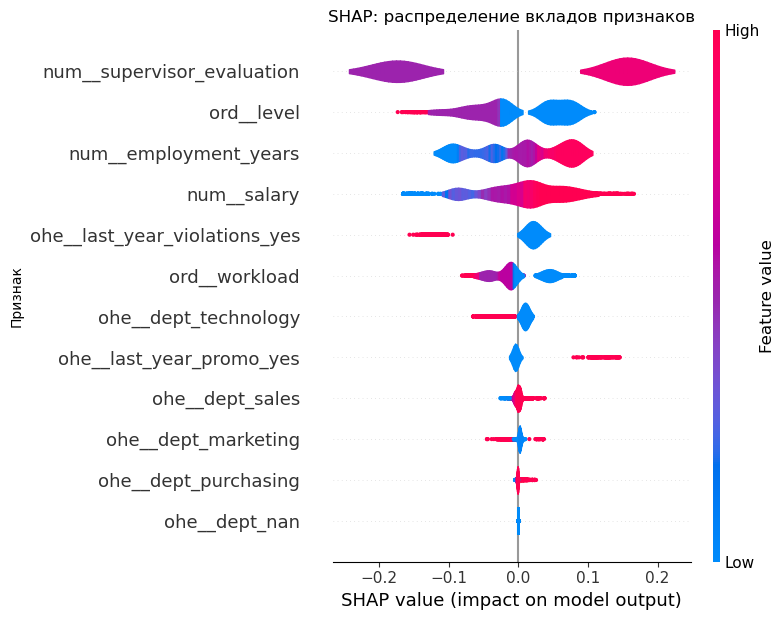

In [43]:
preprocessor = rs.best_estimator_.named_steps['preprocessor']
model        = rs.best_estimator_.named_steps['models']

X_train_trans = preprocessor.transform(job_X_train_ml)

feature_names = preprocessor.get_feature_names_out()
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_trans)

shap.summary_plot(
    shap_values,
    X_train_trans,
    feature_names=feature_names,
    plot_type='violin',
    color=plt.get_cmap("coolwarm"),
    show=False
)

plt.ylabel("Признак")
plt.xlabel("SHAP value (impact on model output)")
plt.title("SHAP: распределение вкладов признаков")
plt.tight_layout()
plt.show()



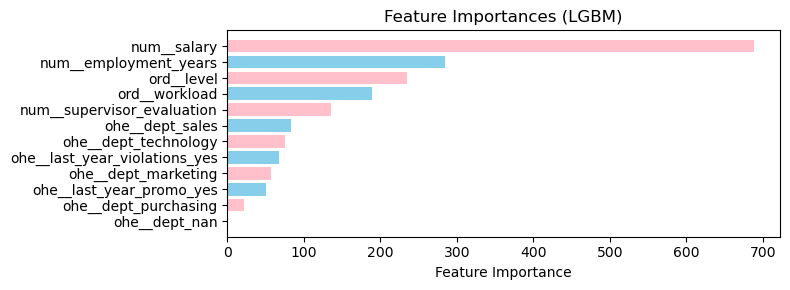

In [44]:
best_pipe = rs.best_estimator_

feature_names = best_pipe.named_steps['preprocessor'] \
                         .get_feature_names_out()

importances = best_pipe.named_steps['models'] \
                       .feature_importances_

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=True)

plt.figure(figsize=(8, len(fi) * 0.25))
colors = ['skyblue' if i % 2 == 0 else 'pink' 
          for i in range(len(fi))]
plt.barh(fi['feature'], fi['importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (LGBM)')
plt.tight_layout()
plt.show()


1. На графике важности признаков (bar-plot) видно, что на модель больше всего влияют четыре фактора: размер зарплаты, продолжительность стажа, оценка со стороны руководителя и уровень должности. Все остальные признаки (отдел, прошлые нарушения, получение промо) имеют значительно меньший вес.

2. SHAP-график показывает, как именно эти четыре ключевых фактора двигают прогноз: высокая зарплата и длительный стаж поднимают предсказанный уровень удовлетворённости, а наличие нарушений в прошлом году его понижает. Оценка руководителя и уровень должности могут как усиливать, так и ослаблять прогноз в зависимости от конкретного сотрудника.

3. В целом оба подхода говорят об одном и том же: модель принимает решения в первую очередь на основе финансовых и карьерных показателей (зарплата, стаж, фидбек от руководства, уровень ответственности), а все остальные факторы лишь незначительно корректируют итоговый результат.


## Итоговый вывод | Задача 1<a name="15"></a> 

В результате проведенной нами работы, была проведена загрузка и предобработка данных. Было обнаружено 
1) job_X_train:
    * 4000 значений
    * Количество пропусков: 10
2) job_X_test:
    * 2000 значений
    * Количество пропусков: 3

А также в результате проверки на неявные дубликаты выяснили, что **job_X_test** имеет:
* dept - пустая строка
* level - sinior (правильно - senior)
* workload - пустая строка

В результате предобработки 
1) Пропущенные числовые значения заменены на самые часто втречающиеся при помощи пайплайна SimpleImputer
2) Пропущенные категориальные значения заменены на NaN
3) Была исправлена синтаксическая ошибка (sinior --> senior)

----------
По результатам анализа данных сделаны выводы о том, что:
1) Статистически, больше всех получают IT-шники, а меньше всех - департамент продаж. Неравенство оплаты туда может влиять на желание сотрудников оставаться на своем месте
2) Дольше в компании задерживаются те сотрудники, которых недавно повышают. Наверное, это очень важно для профессиональной мотивации
3) Те, кто недавно получал выговор намного меньше удовлетворены своей работой. Интересно, что было первым? Неудовлетворенность вызвала пофигизм и наплевательство или Наказания заставили опустить сотрудников руки? Это мы выясним
4) В компании больше всего бедных продажников. Возможно их низкая оплата труда в купе с их количеством делают компании плохую статистику по текучке?
2) Уравновешивает их второй по численности штат айтишников, которые, веротяно, довольны своей заработной платой (особенно сеньоры и мидлы), которых более половины
3) В компании очень мало повышают, но при этом намного чаще делают выговоры. Вероятно, это тоже играет свою роль и руководство рассмотрит идею о пересмотре соотношения кнута и пряника в управленческих процессах

-----------

Корреляционный анализ данных показал, что 
* Сильнее всего целевой признак (job_satisfaction) коррелирует с оценкой супервайзера, наличием нарушений в прошлом году и с количеством отработанных лет. Веротяно, не хорошо работают те, кого высоко оценили, а высоко оценивают тех, кто доволен работой и делает ее хорошо.
* Удовлетворённость сильно связана с оценкой руководителя (≈0.76), но мало — с зарплатой (≈0.17).
* Оклад коррелирует с нагрузкой (≈0.79), уровнем (≈0.72) и стажем (≈0.48).
* Нарушения прошлого года почти не зависят от зарплаты и уровня, но умеренно связаны с удовлетворённостью (≈0.56) и оценкой босса (≈0.18).
* Повышения за год слабо коррелируют с зарплатой (≈0.22) и стажем (≈0.18), практически не с нарушениями.
* Материальные и статусные метрики (уровень, нагрузка, оклад) образуют один кластер, а эмоциональные показатели (удовлетворённость, нарушения) — скорее отражают качество руководства.

------------

Затем был подготовлен и использован пайплайн. По результатам его работы лучшую модель исследовали дополнительно:

1) Большое количество итераций для модели позволило ее улучшить и получить значение на тестовой выборке 10.79 (прирост качества 5.8 п.п.)
2) Уточненная лучшая модель - это LGBMRegressor(max_depth=13, n_estimators=145)

Была исследована важность признаков:
1. На графике важности признаков (bar-plot) видно, что на модель больше всего влияют четыре фактора: размер зарплаты, продолжительность стажа, оценка со стороны руководителя и уровень должности. Все остальные признаки (отдел, прошлые нарушения, получение промо) имеют значительно меньший вес.

2. SHAP-график показывает, как именно эти четыре ключевых фактора двигают прогноз: высокая зарплата и длительный стаж поднимают предсказанный уровень удовлетворённости, а наличие нарушений в прошлом году его понижает. Оценка руководителя и уровень должности могут как усиливать, так и ослаблять прогноз в зависимости от конкретного сотрудника.

3. В целом оба подхода говорят об одном и том же: модель принимает решения в первую очередь на основе финансовых и карьерных показателей (зарплата, стаж, фидбек от руководства, уровень ответственности), а все остальные факторы лишь незначительно корректируют итоговый результат.


# Задача 2: Предсказание увольнения сотрудника из компании<a name="16"></a> 

## Загрузка данных<a name="17"></a> 

In [45]:
try:
    quit_X_train = pd.read_csv('train_quit.csv')
    quit_X_train.head(2)
except:
    quit_X_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    display(quit_X_train.sample(3))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
577,686058,technology,junior,medium,2,no,no,5,32400,no
3934,213758,sales,junior,low,2,no,no,1,12000,yes
481,692365,sales,junior,low,2,no,no,4,18000,no


In [46]:
quit_X_test = job_X_test_ml.copy(deep=True)

In [47]:
try:
    quit_y_test = pd.read_csv('test_target_quit.csv')
    quit_y_test.head(2)
except:
    quit_y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    display(quit_y_test.sample(3))

,id,quit
658,217807,no
1880,656284,no
147,740123,yes


## Предобработка данных<a name="18"></a> 

In [48]:
dfs = [quit_X_train, quit_y_test]

for entry in dfs:
    describe_dataset(entry)

Название датасета: entry
Пример строк (sample 3):


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3853,412950,sales,junior,medium,2,no,no,5,28800,no
3908,182316,sales,middle,medium,4,no,no,4,33600,no
3300,614175,purchasing,middle,medium,8,no,yes,2,37200,no


Количество пропусков: 0
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Название датасета: entry
Пример строк (sample 3):


,id,quit
1573,284445,no
1380,172242,no
1233,667957,no


Количество пропусков: 0
Количество дубликатов: 0
Информация о датасете (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB



Типы данных в порядке, пропусков и дубликатов тоже нет. Прогоним на неявное дублицирование:

In [49]:
for entry in dfs:
    show_non_numeric(entry)

Название датафрейма: entry
Уникальные нечисловые значения:
  dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
  level: ['middle', 'junior', 'sinior']
  workload: ['high', 'medium', 'low']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
  quit: ['no', 'yes']
----------------------------------------

Название датафрейма: entry
Уникальные нечисловые значения:
  quit: ['yes', 'no']
----------------------------------------



Снова орфографическая ошибка с sinior. Исправлю это

In [50]:
quit_X_train['level'] = quit_X_train['level'].replace('sinior', 'senior')

In [51]:
for entry in dfs:
    show_non_numeric(entry)

Название датафрейма: entry
Уникальные нечисловые значения:
  dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
  level: ['middle', 'junior', 'senior']
  workload: ['high', 'medium', 'low']
  last_year_promo: ['no', 'yes']
  last_year_violations: ['no', 'yes']
  quit: ['no', 'yes']
----------------------------------------

Название датафрейма: entry
Уникальные нечисловые значения:
  quit: ['yes', 'no']
----------------------------------------



Потом в пайплайне закодируем 'no' и 'yes'.

Приведу idшки к индексам

In [52]:
quit_y_test = quit_y_test.set_index('id')
quit_X_test = quit_X_test.merge(quit_y_test, right_index=True, left_index=True)
quit_X_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes
109582,technology,middle,low,3,no,no,2,21600,yes
305653,technology,junior,low,1,no,no,3,14400,yes


Первая часть пайплайна - LabelEncoder

In [53]:
y_train = quit_X_train['quit']
y_test  = quit_X_test ['quit']

laben = LabelEncoder()
y_train_enc = laben.fit_transform(y_train)
y_test_enc  = laben.transform(y_test)

quit_X_train['quit'] = y_train_enc
quit_X_test ['quit'] = y_test_enc

In [54]:
display(quit_X_test.sample(1))
display(quit_X_train.sample(1))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
645413,marketing,middle,low,5,no,no,4,31200,0


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
809,217564,technology,junior,low,1,no,no,5,22800,1


Закодировали успешно

In [55]:
quit_X_train = quit_X_train.set_index('id')

In [56]:
display(quit_X_test.sample(1))
display(quit_X_train.sample(1))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
410542,technology,middle,medium,4,no,no,3,50400,0


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
605118,marketing,junior,low,1,no,no,3,16800,1


Итого после предобработки данных:
1) Закодированъли yes и no LabelEncoder'ом
2) Удалили орфорграфическую ошибку в слове sinior датасета quit_X_train
3) Приведи id к формату индексов и дропнули исходные

## Исследовательский анализ данных<a name="19"></a> 

### Численный анализ<a name="20"></a> 

Давайте рассмотрим, какя доля уволившихся в каждой из категорий, чтобы, возможно, уловить некоторые закономерности

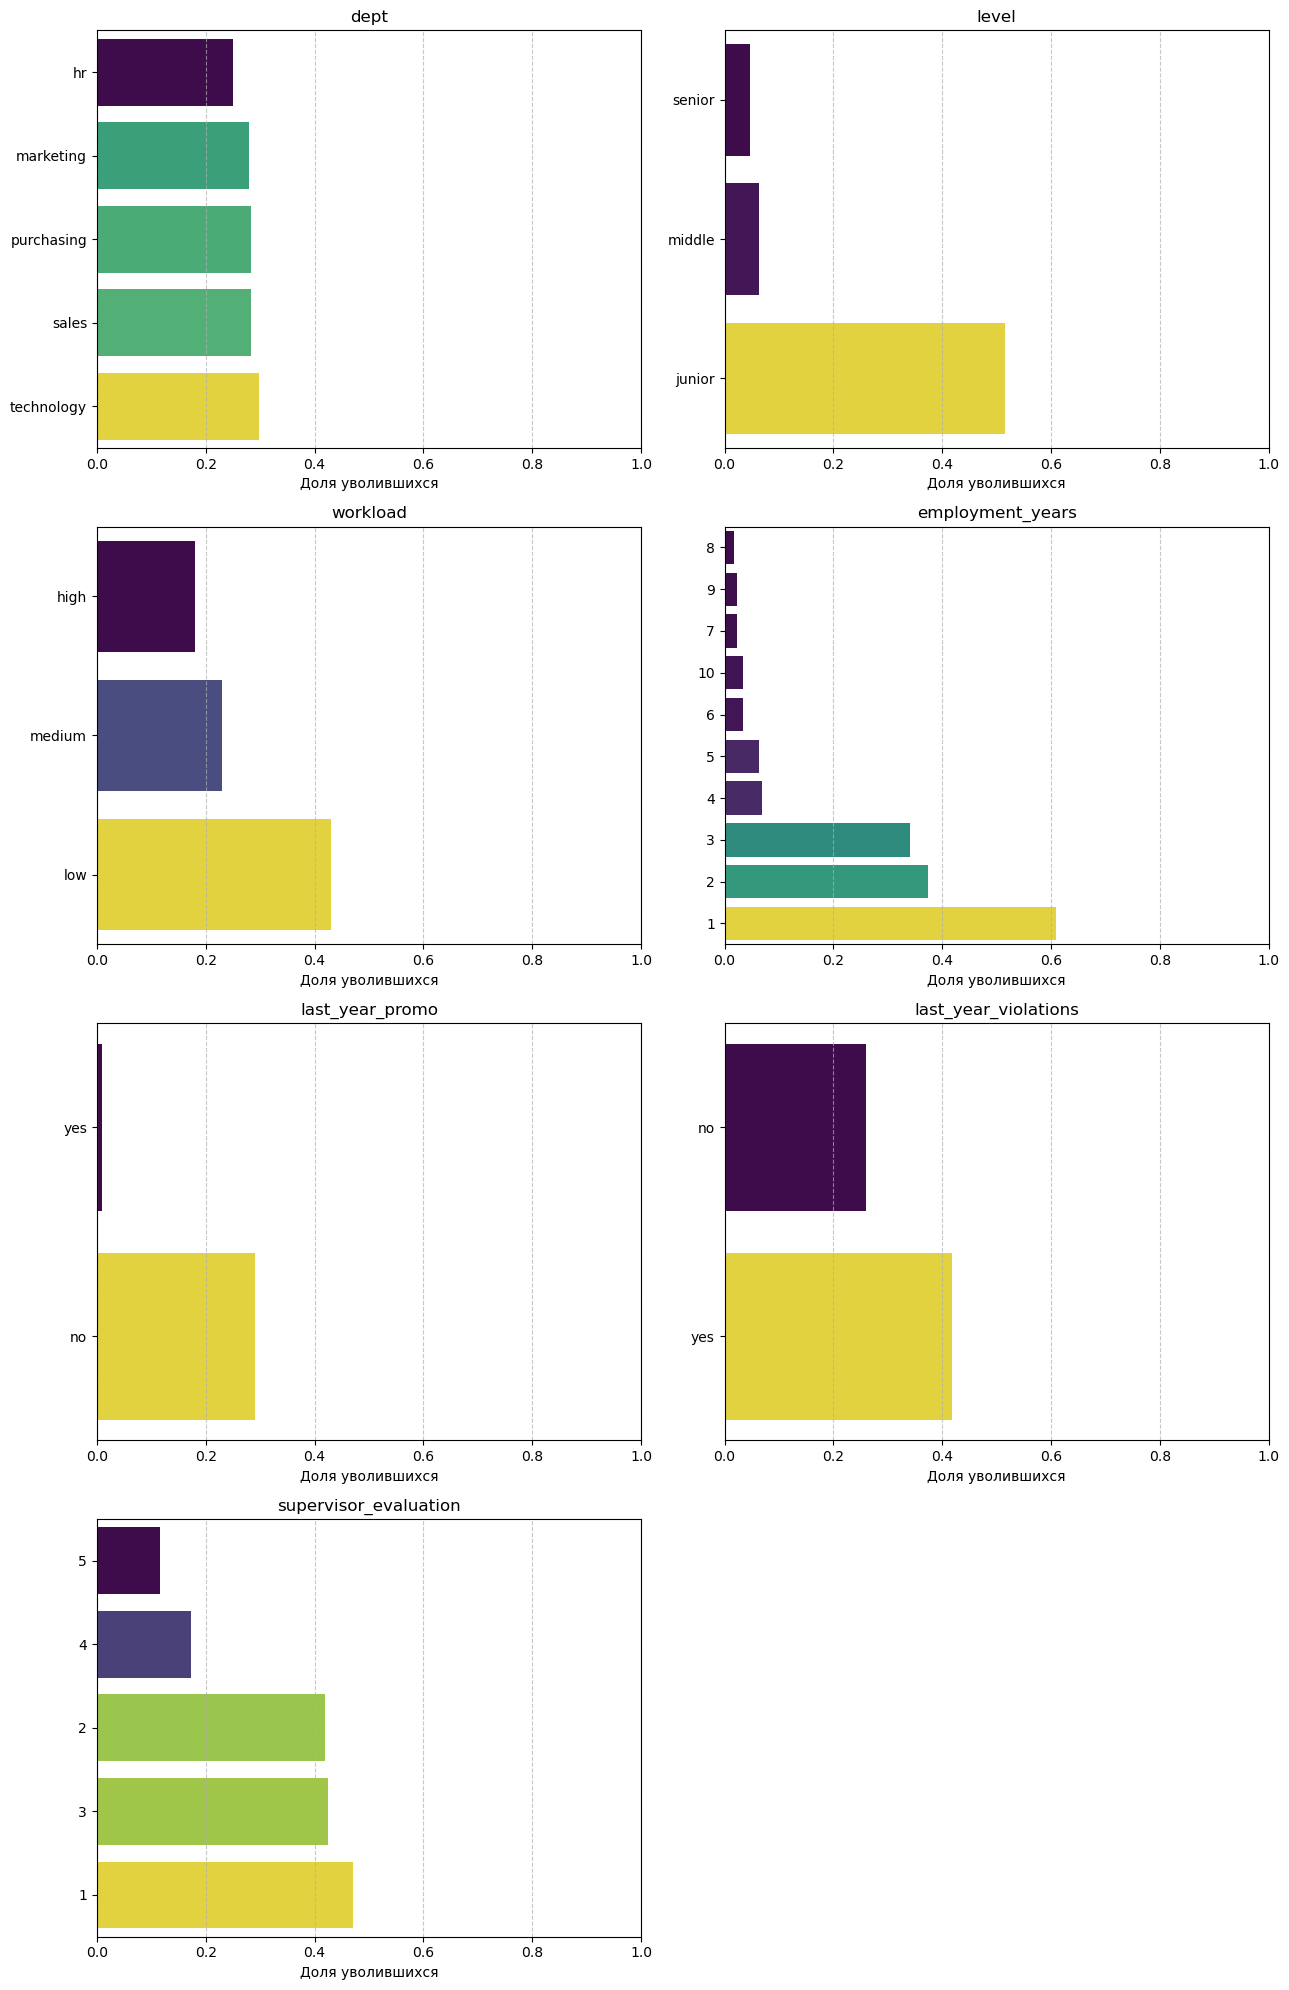

In [57]:
plot_quit_rate_by_all_categories(quit_X_train)

Есть четкая закономерность: 
1) Сотрудники, у которых мало задач редко задерживаются на долго и уволняется почти каждый второй
2) Увольняется более половины младших специалистов, а текучка среди постоянных работников минимальна
3) Очень позитивно на удержание челоовека в компании влияет повышение. Такие на следующий год почти не увольняются
4) Также часто уходят те, кто были плохо оценены супервайзером. Вероятно, это как-то связано и с числом нарущений за последний год

Взглянем на количественное распределение категориальных признаков

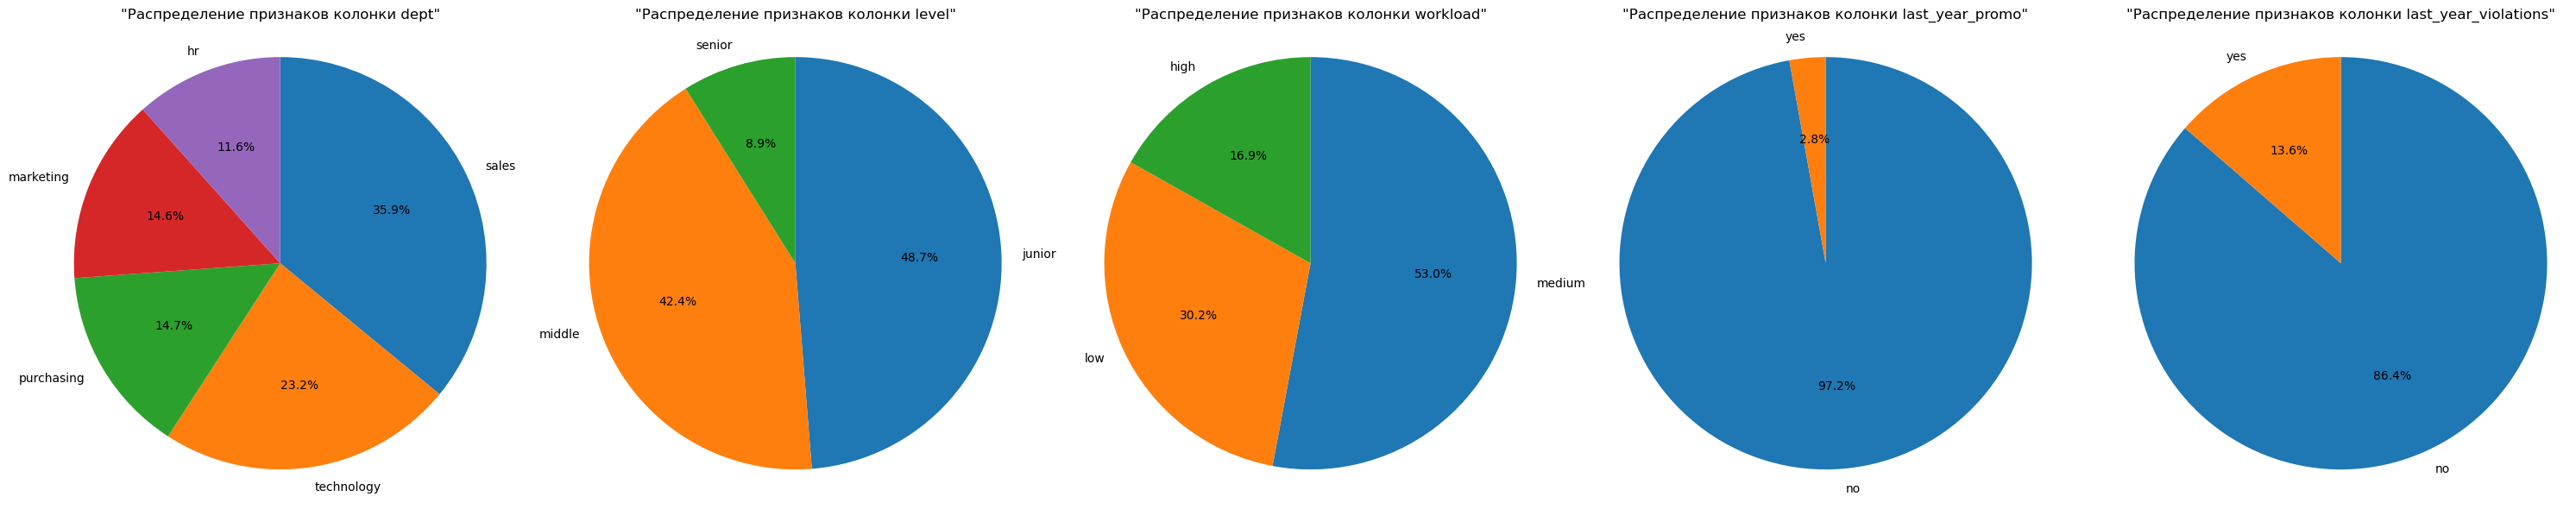

In [58]:
plot_non_numeric_pies(quit_X_train)

При такой страшной текучке джунов их в компании почти половина. Это близко к четверти выбывшего штата ежегодно, что явно должно оакзывать плохое вляние на бизнес процессы. К тому же очень много людей с низкой загрузкой. Но это не самое страшное...

Хуже всего то, что 97% людей не могут получить повышение и, например, выбраться с джунской позиции. Это, кажется, создает ощущение бесперспективности работы и вызывает отток сотрудников.

Что потенциально может сделать бизнес? Например пересмотреть кадровую политику. Вместо трех человек на определенный объём работы нанимать двух, быстрее их грейить и давать больший объём работы. Или увеличить количество грейдов с трех до 10+, чтобы как можно чаще хотя бы и формально, но давать повышения сотрудникам. Это не должно значительно влиять на зарплатный фонд или исполнение обяханностей, но должно возыметь значительный психологический эффект.

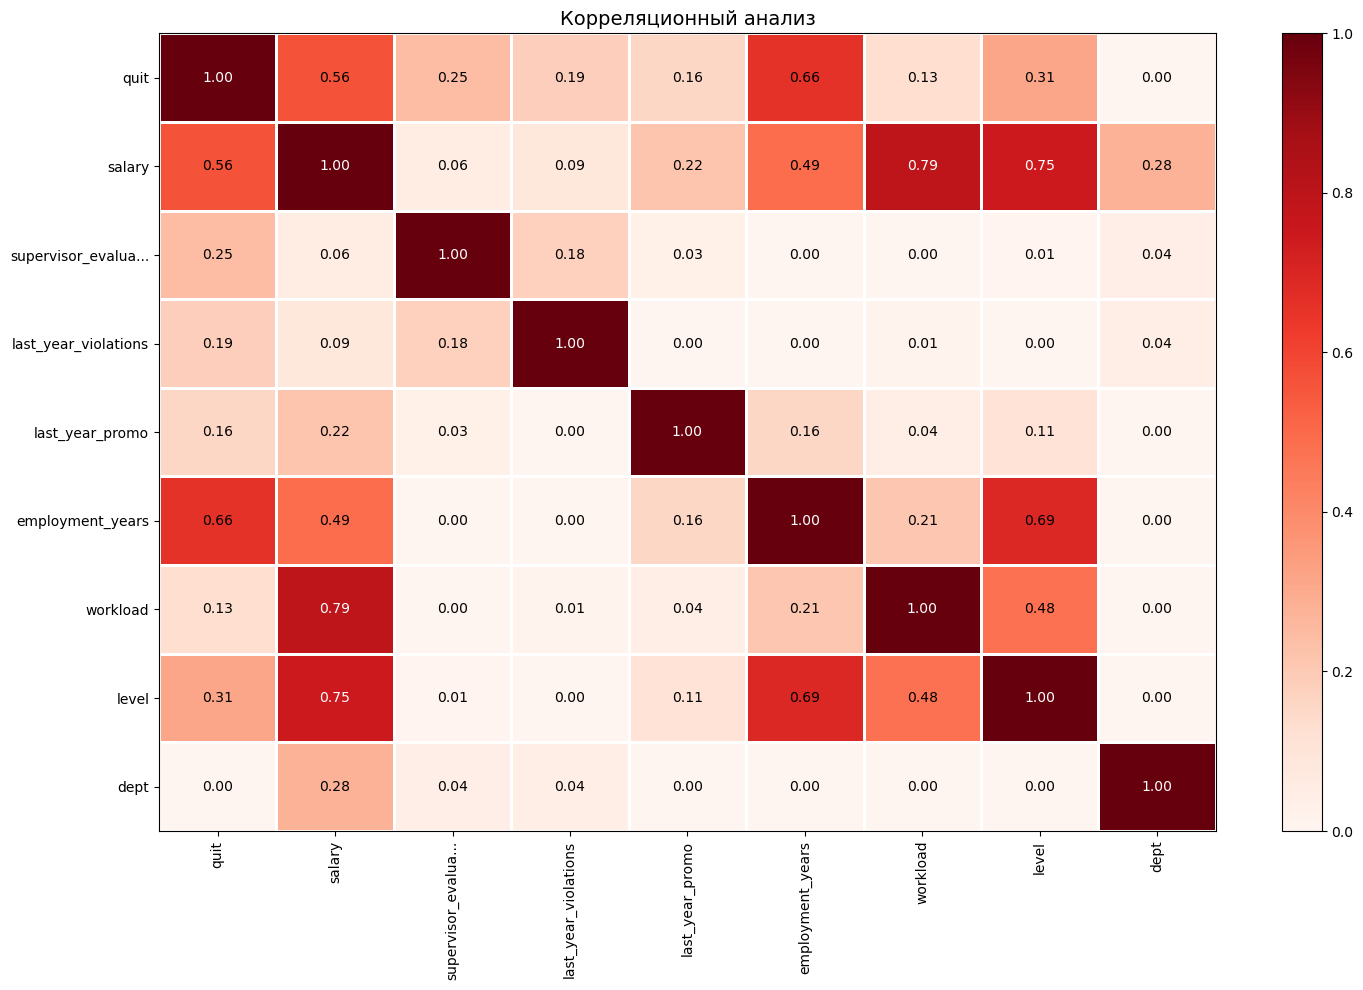

In [59]:
interval_cols = [
    'salary',
    'job_satisfaction_rate',
]

phik_overview = phik_matrix(quit_X_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

Рассмотрим тепловую матрицу корреляции,где таргетное значение - это quit. Данные в ней отражают примерно те же выводы, которые я делал раньше:
1) Сильна связь между зарплатой. Сотрудними, которые мало получают имеют тенденцию к тому, чтобы искать более рыбное место
2) Саммая сильная связь между количеством проведенных лет в компании: много сотрудников не могут удержаться на одном месте и уходят, пока н инвестировали слишком много сил и времени в эту работу
3) Так же сильно влияет уровень. Джуны не особо держася за одно место и их можно понять: джуном можно сразу стать и в дургом месте, где будет лучше. Возможно, это та часть мотивации, работа над ктоорой даст лучше плоды

### Портрет уволившегося сотрудника<a name="21"></a> 

In [60]:
resigned = quit_X_train[quit_X_train['quit'] == 1]
not_resigned = quit_X_train[quit_X_train['quit'] == 0]

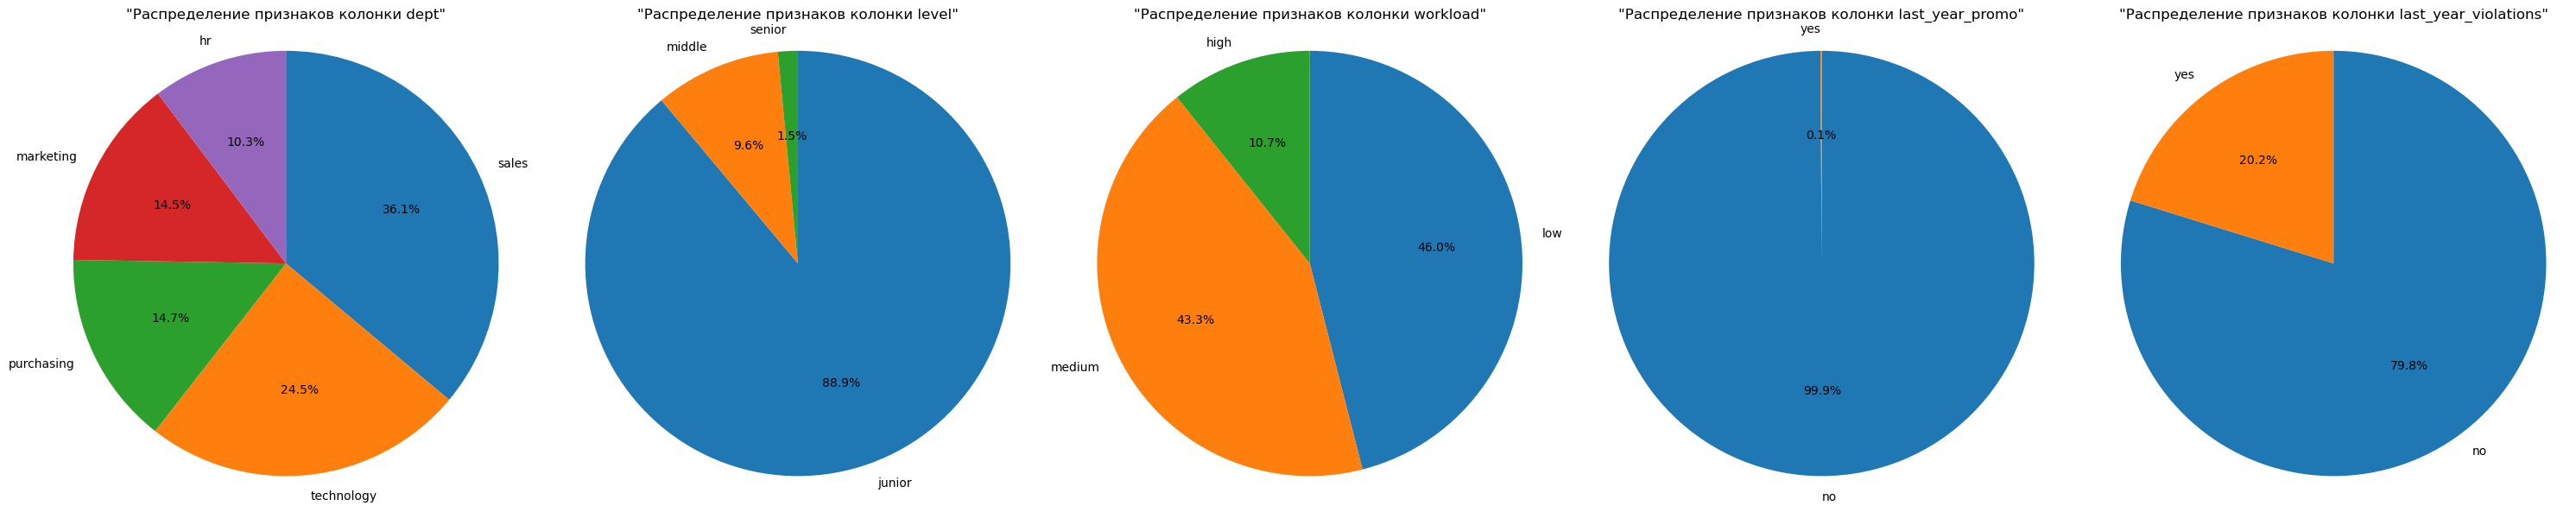

In [61]:
plot_non_numeric_pies(resigned)

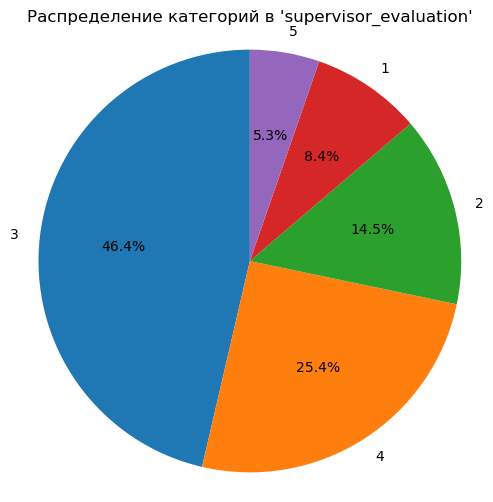

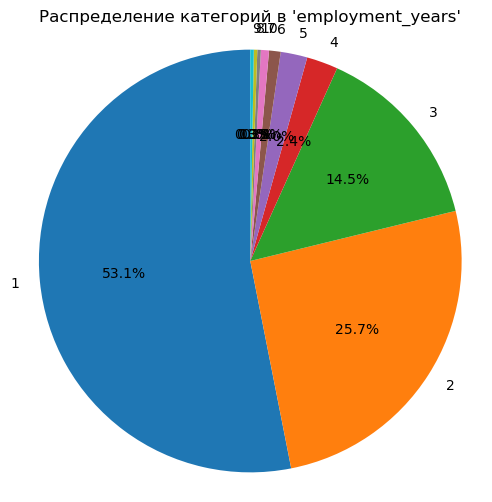

In [62]:
qqq = ['supervisor_evaluation', 'employment_years']

def plot_pie(df: pd.DataFrame, column: str, figsize=(6,6), explode=None):
    counts = df[column].value_counts()

    plt.figure(figsize=figsize)
    counts.plot.pie(
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Распределение категорий в '{column}'")
    plt.ylabel('')
    plt.axis('equal')
    plt.show()

for s in qqq:
    plot_pie(resigned, s)

In [63]:
print('В среднем отработал', resigned['employment_years'].mean())

В среднем отработал 1.8448581560283688


In [64]:
print('В среднем получал', resigned['salary'].mean())

В среднем получал 23885.106382978724


Составим портрет среднестатистического уволившегося:
1) Проработал почти 2 года в компании
    * Как показывают графики - более половины - это те, кто проработал 1 год
3) Их отдела продаж или разработки
4) Джуниор специалист
5) С невысокой загрузкой (чаще - низкой)
6) Гарантированно не получавший повышение более года
7) Скорее всего не получавший взысканий в прошлом году
8) Средняя зарплата: 23885.106382978724 (не знаю от какого года датасет, но это очень мало.)
9) Имеет среднюю оценку супервайзера - 3, что, вероятно, бьет по самолюбию и желанию продолжать тут работать

### Проверка гипотезы аналитиков<a name="21"></a> 

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение:

In [65]:
target_dependence = job_y_test.merge(quit_y_test, on='id', how='left')

In [66]:
target_dependence

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


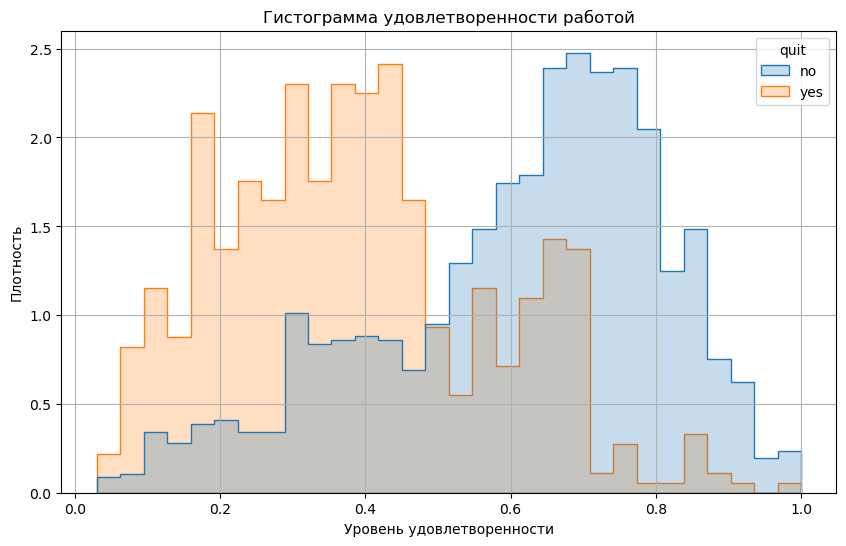

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(data=target_dependence, x='job_satisfaction_rate', hue='quit', bins=30, kde=False, element='step', stat='density', common_norm=False)

plt.title('Гистограмма удовлетворенности работой')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

Результат довольно ожидаемый. В среднем, уволившийся в два раза меньше удовлетворен своей работой, чем те, кто остались

## Добавление нового входного признака<a name="22"></a> 

In [68]:
job_X_train_merge = job_X_train.set_index('id')

In [69]:
job_X_train_merge

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...
457950,technology,junior,high,2,no,no,3,46800,0.45
957499,sales,junior,medium,2,no,no,4,21600,0.68
533318,sales,middle,low,7,no,no,5,24000,0.76


In [70]:
qq = job_X_train_merge.merge(quit_X_train, right_index=True, left_index=True)
qq

,dept_x,level_x,workload_x,employment_years_x,last_year_promo_x,last_year_violations_x,supervisor_evaluation_x,salary_x,job_satisfaction_rate,dept_y,level_y,workload_y,employment_years_y,last_year_promo_y,last_year_violations_y,supervisor_evaluation_y,salary_y,quit
id,,,,,,,,,,,,,,,,,,


Кажется у нас нет общих id. Придется предсказать значения

In [71]:
quit_train_predicted = rs.best_estimator_.predict(quit_X_train)

quit_X_train_ml = quit_X_train.copy(deep=True)
quit_X_train_ml['job_satisfaction_rate'] = quit_train_predicted
quit_X_train_ml

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.646567
814010,sales,junior,medium,2,no,no,4,27600,0,0.827605
155091,purchasing,middle,medium,5,no,no,1,37200,0,0.395430
257132,sales,junior,medium,2,no,yes,3,24000,1,0.326384
910140,marketing,junior,medium,2,no,no,5,25200,0,0.762908
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,0,0.479348
672059,sales,middle,high,9,no,no,4,52800,0,0.809790
536432,purchasing,junior,low,2,no,yes,4,12000,1,0.542075


Добавлю предсказанные значения у job_y_test_pred

In [72]:
quit_X_test_ml = quit_X_test.copy(deep=True)
quit_X_test_ml['job_satisfaction_rate'] = job_y_test_pred
quit_X_test_ml

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0,0.819827
686555,hr,junior,medium,1,no,no,4,30000,0,0.655367
467458,sales,middle,low,5,no,no,4,19200,0,0.664826
418655,sales,middle,low,6,no,no,4,19200,0,0.663261
789145,hr,middle,medium,5,no,no,5,40800,0,0.801860
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,1,0.495185
109582,technology,middle,low,3,no,no,2,21600,1,0.188981
305653,technology,junior,low,1,no,no,3,14400,1,0.156058


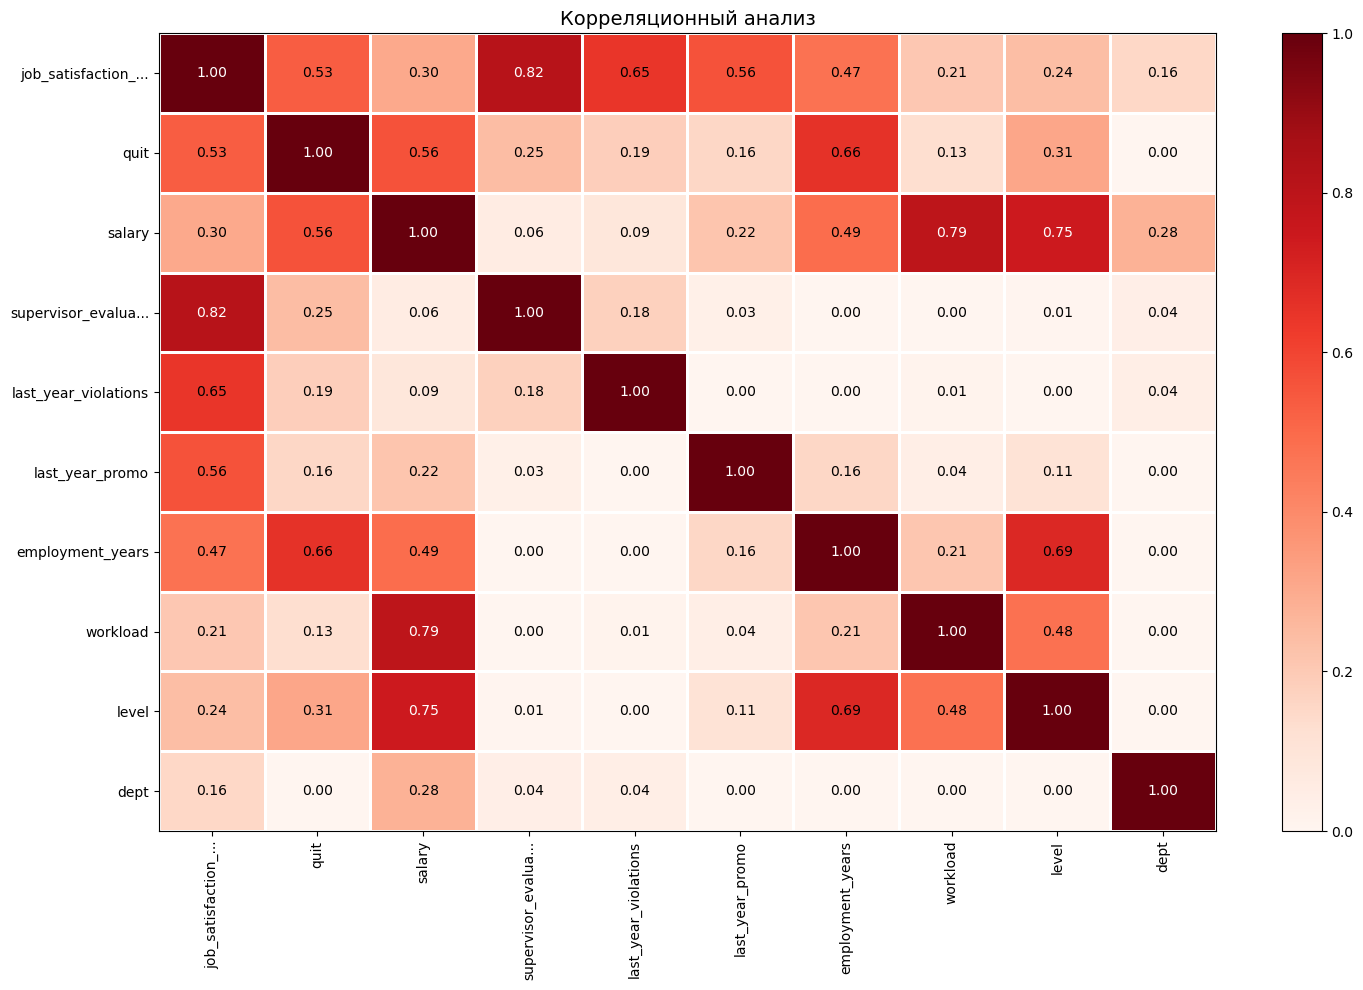

In [73]:
phik_overview = phik_matrix(quit_X_train_ml, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

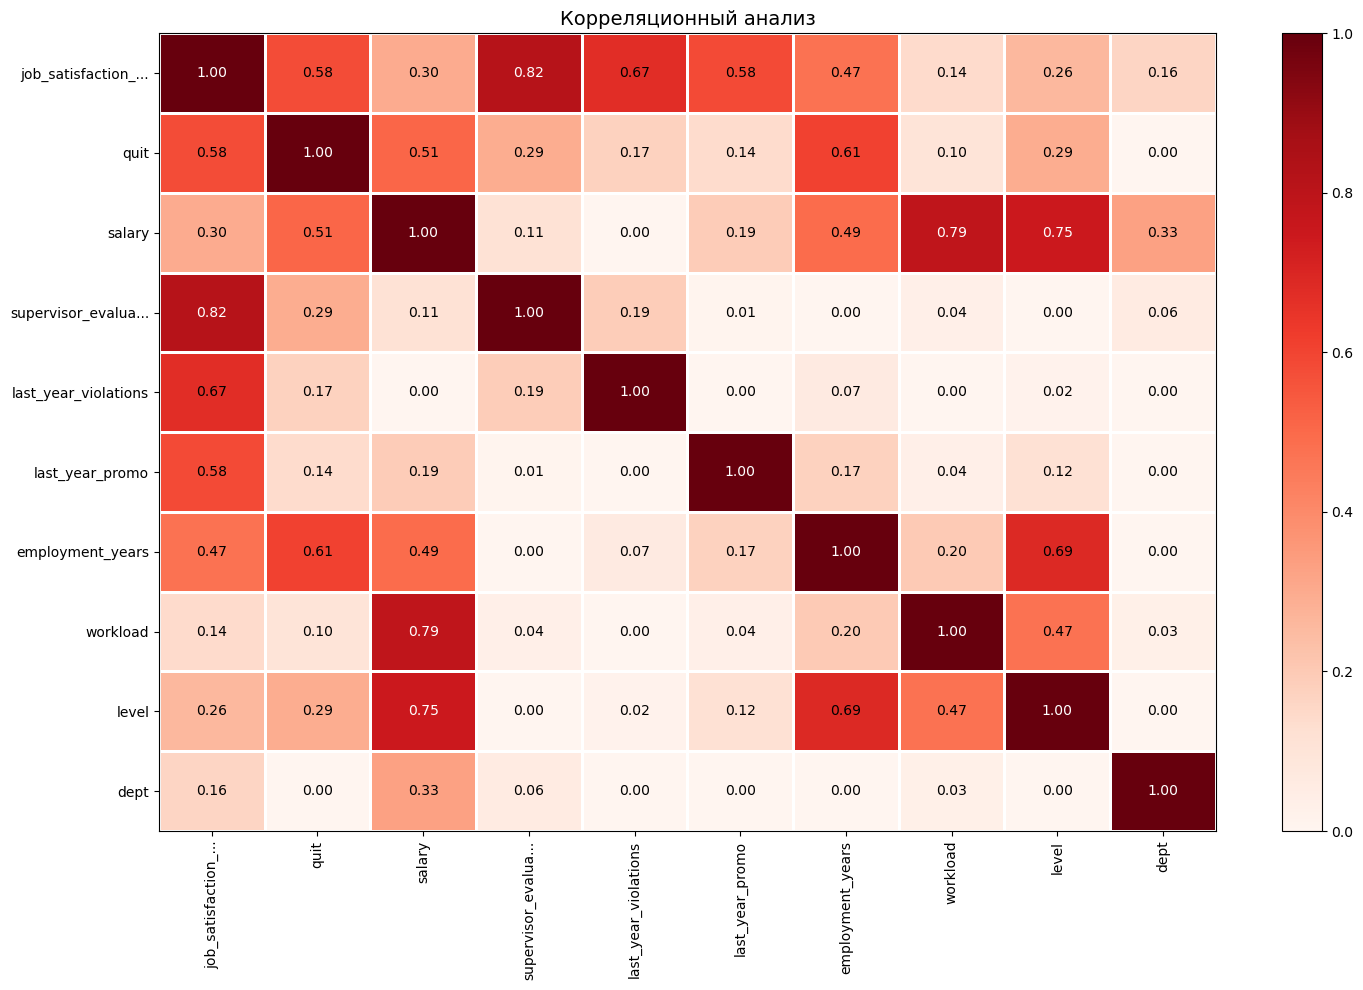

In [74]:
phik_overview = phik_matrix(quit_X_test_ml, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляционный анализ',
    fontsize_factor=1,
    figsize=(15, 10),
)

Я проверил данные на возможную мультиколлинеарность. В целом: явной катастрофы тут нет (нет пар с |corr|>0.9), так что пока оставлю все имеющиеся признаки, но будем учитывать это в дальнейшем

## Подготовка данных<a name="23"></a> 

In [75]:
quit_y_train_ml = quit_X_train_ml['quit']
quit_y_train_ml.head(2)

quit_X_train_ml.duplicated().sum()

quit_X_train_ml = quit_X_train_ml.drop_duplicates()
quit_X_train_ml.duplicated().sum()

quit_y_train_ml = quit_X_train_ml['quit']
quit_X_train_ml = quit_X_train_ml.drop('quit', axis=1)

quit_y_test_ml = quit_X_test_ml['quit']
quit_y_test_ml.head(2)

quit_X_test_ml.duplicated().sum()

#quit_X_test_ml = quit_X_test_ml.drop_duplicates()
quit_X_test_ml.duplicated().sum()

quit_y_test_ml = quit_X_test_ml['quit']
quit_X_test_ml = quit_X_test_ml.drop('quit', axis=1)

quit_y_train_ml = quit_y_train_ml[quit_y_train_ml.index.isin(quit_X_train_ml.index)]

In [76]:
#=============================================================================================

In [77]:
num_columns.append('job_satisfaction_rate')

pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

## Работа с новым пайплайном<a name="24"></a> 

In [ ]:
param_grid_all = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1)],
        'models__n_estimators': range(80, 120),
        'models__max_depth': range(1, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsClassifier(
            n_jobs=-1,
            weights='distance')],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
]

rs_clf = RandomizedSearchCV(
    pipe_final_2,
    param_distributions=param_grid_all,
    n_iter=100,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 1) Подбор гиперпараметров только на train
rs_clf.fit(quit_X_train_ml, quit_y_train_ml)

print("Лучший классификатор:", rs_clf.best_estimator_['models'])
print("ROC-AUC на CV (train):", rs_clf.best_score_)

# 2) один раз тестируем финальную модель
probs_test = rs_clf.best_estimator_.predict_proba(quit_X_test_ml)[:,1]
roc_test = roc_auc_score(quit_y_test_ml, probs_test)
print("ROC-AUC на тесте:", roc_test)


Лучшая модель - 

1) Лучший классификатор: LGBMClassifier(max_depth=2, n_estimators=110, n_jobs=-1, random_state=42,  verbose=-1)2) 
ROC-AUC на CV (train): 0.92116283597107
3) 8
ROC-AUC на тесте: 0.91392013400173



In [ ]:
best_pipeline = rs_clf.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']

feature_names = best_pipeline[:-1].get_feature_names_out()

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_.ravel())
else:
    raise AttributeError("Модель не поддерживает отображение важности признаков")

indices = np.argsort(importances)[::-1]
sorted_names = feature_names[indices]
sorted_importances = importances[indices]

# Рисуем
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_names, rotation=90)
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.title("Feature Importances — лучшая модель")
plt.tight_layout()
plt.show()


Предположение подтвердилось, очень важна метрика удовлетворенности работой, как и предсказывали аналитики. Также решающими факторами, толкающими к уво являются нагрузка, 

#### Подвывод по модели 2<a name="25"></a> 

Лучшая модель -

LGBMClassifier(max_depth=4, n_estimators=98, n_jobs=-1, random_state=42, verbose=-1)
ROC-AUC лучшей модели на кросс-валидации (TRAIN): 0.9410081065994605
ROC-AUC: 0.9273345976807127

## Итоговый вывод | Задача 2<a name="26"></a> 

Была проведена загрузка и предобработка данных. Итого после предобработки данных:
1) Закодированъли yes и no LabelEncoder'ом
2) Удалили орфорграфическую ошибку в слове sinior датасета quit_X_train
3) Приведи id к формату индексов и дропнули исходные

-----

По результатам анализа новых данных сделали выводы:


1) Сотрудники, у которых мало задач редко задерживаются на долго и уволняется почти каждый второй
2) Увольняется более половины младших специалистов, а текучка среди постоянных работников минимальна
3) Очень позитивно на удержание челоовека в компании влияет повышение. Такие на следующий год почти не увольняются
4) Также часто уходят те, кто были плохо оценены супервайзером. Вероятно, это как-то связано и с числом нарущений за последний год

Проанализировав еще и категориальные признаки, стало ясно, что при такой страшной текучке джунов их в компании почти половина. Это близко к четверти выбывшего штата ежегодно, что явно должно оакзывать плохое вляние на бизнес процессы. К тому же очень много людей с низкой загрузкой. Но это не самое страшное...

Хуже всего то, что 97% людей не могут получить повышение и, например, выбраться с джунской позиции. Это, кажется, создает ощущение бесперспективности работы и вызывает отток сотрудников.

Что потенциально может сделать бизнес? Например пересмотреть кадровую политику. Вместо трех человек на определенный объём работы нанимать двух, быстрее их грейить и давать больший объём работы. Или увеличить количество грейдов с трех до 10+, чтобы как можно чаще хотя бы и формально, но давать повышения сотрудникам. Это не должно значительно влиять на зарплатный фонд или исполнение обяханностей, но должно возыметь значительный психологический эффект.

----- 

Затем мы составили портрет уволившегося сотрудника:

1) Проработал почти 2 года в компании
2) Их отдела продаж или разработки
3) Джуниор специалист
4) С невысокой загрузкой (чаще - низкой)
5) Гарантированно не получавший повышение более года
6) Скорее всего не получавший взысканий в прошлом году

----- 

Оценили гипотезу аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Определили, что, в среднем, уволившийся в два раза меньше удовлетворен своей работой, чем те, кто остались

-----

Добавили новый входной признак и обработали пайплайном несколько моделей, лучшая модель - 

1) LGBMClassifier(max_depth=4, n_estimators=98, n_jobs=-1, random_state=42, verbose=-1)
2) ROC-AUC лучшей модели на кросс-валидации (TRAIN): 0.9410081065994605
3) ROC-AUC: 0.9273345976807127

-----

Оценив важность признаков смогли сделать вывод о том, что на увольнение из компании сильнее всего толкают:

1) Низкий должностной урорвень (и, вероятно, рутинные и мусорные задачи)
2) Малое количество отработанных лет без значительных успехов
3) Низкая удовлетворенность работой
4) Недостаточная зарплата

# Советы бизнесу<a name="27"></a> 

По результатам проведенного исследлвания можно предлоить кадровому отдлу и высшему руководство несколько советов:

1) **Сократить число сотрудников на джуниорской позиции, отдавать работу меньшему числу сотрудников. Это позволит повысить их вовлеченность, увеличит их заработную плату (как за счет сокращения кадрового фонда, так и за счет часовработы)**
2) Быстрее грейдить джунов как минимум в миддлы. ОТойти от модели с тремя грейдами и разбавить ее промежуточными грейдами, чтобы сотрудник чувствовал свою нужность и прогресс в карьере
3) Строже относиться к отбору персонала и брать лучших. Заставлять джунов эмоционально вкладываться в получение работы (тестирования, многоступенчатый отбор и т.д.) Но с этим очень легко переусердствовать
4) Часть рутинных задач отдать фрилансерам или на аутсорс, если возможно. Сосредоточиться на главном и интересном, для чего привлекать более квалифицированную трудовую силу